In [1]:
WORKING_DIR = "/home/xavier/Documents/DAE_project"

# Aggregate segmentation analysis

## Copy end frame images

In [2]:
import os
import shutil

IMG_DIR = f"{WORKING_DIR}/dataset/Roy_training/images"
LAST_FRAMES_DIR = f"{WORKING_DIR}/images/figure5/final_frames/originals"
os.makedirs(LAST_FRAMES_DIR, exist_ok=True)

for run_id in os.listdir(IMG_DIR):
    for scope_id in os.listdir(f"{IMG_DIR}/{run_id}"):
        frames = sorted(os.listdir(f"{IMG_DIR}/{run_id}/{scope_id}"))
        last_frame = frames[-1]
        src_path = f"{IMG_DIR}/{run_id}/{scope_id}/{last_frame}"
        dst_path = f"{LAST_FRAMES_DIR}/{last_frame}"
        if not os.path.exists(dst_path):
            shutil.copyfile(src_path, dst_path)

## Select strains with visually detectable aggregates
## Perform image segmentation in matlab
## Filter the results

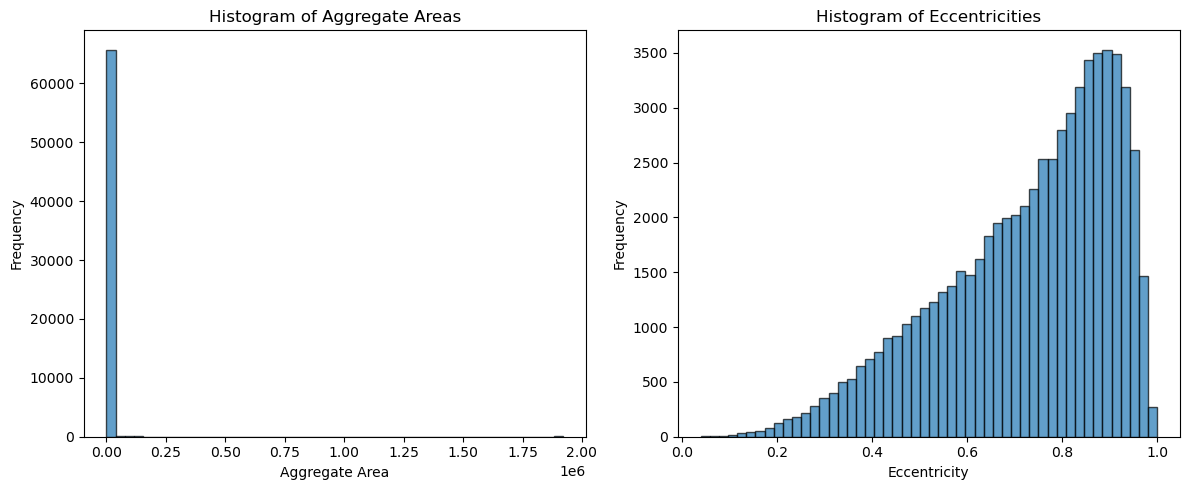

In [3]:
import os
import re
from copyreg import pickle

import cv2
import shutil
import numpy as np
import pandas as pd
from skimage import measure
from matplotlib import pyplot as plt

import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['text.usetex'] = False

PROCESSED_DIR = f"{WORKING_DIR}/images/figure5/final_frames/segmented"
SEG_DIR = f"{WORKING_DIR}/images/figure5/final_frames/filtered"
FAILURE_DIR = f"{WORKING_DIR}/images/figure5/final_frames/failures"

os.makedirs(SEG_DIR, exist_ok=True)
os.makedirs(FAILURE_DIR, exist_ok=True)

areas = []
eccentricities = []


def extract_run_scope(filename):
    pattern = r"Run(\d{4})_scope(\d+)-00_\d{4}\.tif"
    match = re.match(pattern, filename)

    if match:
        run_id = int(match.group(1))  # Extract and convert to integer
        scope_id = int(match.group(2))  # Extract and convert to integer
        return run_id, scope_id
    else:
        return None, None  # Return None if pattern does not match


def has_sharp_corners(region_mask, threshold_corners=5):
    """Detect sharp corners using Harris Corner Detector."""
    gray = np.float32(region_mask)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)

    # Threshold for strong corners
    corner_count = np.sum(dst > 0.01 * dst.max())

    return corner_count > threshold_corners


for image in os.listdir(PROCESSED_DIR):
    bw = cv2.imread(os.path.join(PROCESSED_DIR, image), cv2.IMREAD_UNCHANGED)
    labeled_bw = measure.label(bw)
    props = measure.regionprops(labeled_bw)
    too_big = False
    failure_cnt = 0
    ecc_count = 0
    axis_ratio_count = 0
    sharp_edge_count = 0
    for prop in props:
        if prop.area < 100:
            failure_cnt += 1
        elif prop.area > 100000:
            failure_cnt += 1
            too_big = True
        if prop.eccentricity > 0.8:
            ecc_count += 1
        if prop.major_axis_length > 3 * prop.minor_axis_length:  # Check axis ratio
            axis_ratio_count += 1

        # circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0
        # if circularity < 0.2:  # Threshold for sharp-edged or irregular shapes
        #     sharp_edge_count += 1

        areas.append(prop.area)
        eccentricities.append(prop.eccentricity)
    if (failure_cnt > len(props) // 2) or too_big or (ecc_count > len(props) // 2) or (axis_ratio_count > 0) or (
            sharp_edge_count > 0):
        shutil.copy(os.path.join(PROCESSED_DIR, image),
                    os.path.join(FAILURE_DIR,
                                 f"Big{too_big}_Axis{axis_ratio_count}_Sharp{sharp_edge_count}_Ecc{ecc_count}_Cnt{len(props)}_{image}"))
    else:
        shutil.copy(os.path.join(PROCESSED_DIR, image), os.path.join(SEG_DIR, image))
# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(areas, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Aggregate Area")
plt.ylabel("Frequency")
plt.title("Histogram of Aggregate Areas")

plt.subplot(1, 2, 2)
plt.hist(eccentricities, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Eccentricity")
plt.ylabel("Frequency")
plt.title("Histogram of Eccentricities")

plt.tight_layout()
plt.show()

# Feature Processing
## Resume from MATLAB segmented images
## Process images and illustrate

In [41]:
ORI_DIRS = [LAST_FRAMES_DIR]
OUT_DIR = f"{WORKING_DIR}/images/figure5/final_frames"
SAMPLE_DIR = os.path.join(OUT_DIR, "process")
os.makedirs(SAMPLE_DIR, exist_ok=True)

edge = 512
original_size = [972, 1296]
final_size = [1200, 1600]
ratio = 1600 / 1296
start = 50

center_y = 600
crop_half_height = (512 * ratio) / 2

left_x1, left_x2 = start, start + int(512 * ratio)
right_x1, right_x2 = final_size[1] - start - int(512 * ratio), final_size[1] - start


def filter_by_region(props, y1, y2, x1, x2, size_threshold=300):
    """Filter region properties based on center within a given bounding box and minimum size."""
    filtered_props = [
        p for p in props
        if (y1 <= p.centroid[0] <= y2) and (x1 <= p.centroid[1] <= x2) and (p.area > size_threshold)
    ]
    return filtered_props


def compute_stats(region_props):
    """Compute aggregate statistics (mean, min, max, median, std, sum, count)."""
    if not region_props:
        return {
            "area": (0, 0, 0, 0, 0, 0),
            "perimeter": (0, 0, 0, 0, 0),
            "eccentricity": (0, 0, 0, 0, 0),
            "axis_length": (0, 0, 0, 0, 0),
            "count": 0
        }

    areas = [p.area for p in region_props]
    perimeters = [p.perimeter for p in region_props]
    eccentricities = [p.eccentricity for p in region_props]
    axis_lengths = [p.major_axis_length for p in region_props]

    return {
        "area": (np.mean(areas) / (ratio ** 2) * 4, np.min(areas) / (ratio ** 2) * 4, np.max(areas) / (ratio ** 2) * 4,
                 np.median(areas) / (ratio ** 2) * 4, np.std(areas) / (ratio ** 2) * 4,
                np.sum(areas) / (ratio ** 2) * 4,),
        "perimeter": (
            np.mean(perimeters) / ratio * 2, np.min(perimeters) / ratio * 2, np.max(perimeters) / ratio * 2,
            np.median(perimeters) / ratio * 2, np.std(perimeters) / ratio * 2),
        "eccentricity": (
            np.mean(eccentricities), np.min(eccentricities), np.max(eccentricities), np.median(eccentricities),
            np.std(eccentricities)),
        "axis_length": (np.mean(axis_lengths) / ratio * 2, np.min(axis_lengths) / ratio * 2,
                        np.max(axis_lengths) / ratio * 2,
                        np.median(axis_lengths) / ratio * 2,
                        np.std(axis_lengths) / ratio * 2),
        "count": len(region_props)
    }


def resize_crop(img_dir, resize_by=1., resolution=512, brightness_norm=True, brightness_mean=107,
                locations=None):
    if locations is None:
        locations = ["center"]
    img = cv2.imread(img_dir, cv2.IMREAD_UNCHANGED)
    if img.dtype != np.uint8:
        img = np.uint8(img / 256)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = img.shape
    resize_shape = np.array([img_shape[1] * resize_by, img_shape[0] * resize_by], dtype=int)
    if resize_by != 1:
        img = cv2.resize(img, resize_shape, cv2.INTER_LANCZOS4)
    imgs = []
    for location in locations:
        if location == "left":
            new_img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
            start:start + resolution]
        elif location == "right":
            new_img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
            -start - resolution:-start]
        elif location == "center":
            new_img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
            (resize_shape[0] - resolution) // 2:(resize_shape[0] + resolution) // 2]
        else:
            new_img = img
        if brightness_norm:
            obj_v = np.mean(new_img)
            value = brightness_mean - obj_v
            new_img = cv2.add(new_img, value)
        imgs.append(new_img)
    if len(locations) == 1:
        return imgs[0]
    else:
        return imgs


segments = []
left_crops = []
right_crops = []
for image in os.listdir(SEG_DIR):
    run_id, scope_id = extract_run_scope(image)
    bw = cv2.imread(os.path.join(SEG_DIR, image), cv2.IMREAD_UNCHANGED)
    labeled_bw = measure.label(bw)
    props = measure.regionprops(labeled_bw)

    # Filter regions based on center position
    left_aggregates = filter_by_region(props, center_y - crop_half_height, center_y + crop_half_height, left_x1,
                                       left_x2)
    right_aggregates = filter_by_region(props, center_y - crop_half_height, center_y + crop_half_height, right_x1,
                                        right_x2)

    # Compute statistics
    left_stats = compute_stats(left_aggregates)
    right_stats = compute_stats(right_aggregates)

    overlay = bw.copy()
    for directory in ORI_DIRS:
        if os.path.exists(os.path.join(directory, image[:-3] + 'jpg')):
            lcrop, rcrop = resize_crop(os.path.join(directory, image[:-3] + 'jpg'), brightness_norm=True,
                                       locations=["left", "right"])
            overlay = cv2.imread(os.path.join(directory, image[:-3] + 'jpg'), cv2.IMREAD_UNCHANGED)
            overlay = cv2.resize(overlay, [final_size[1], final_size[0]])
            overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
            break
    left_crops.append(lcrop)
    right_crops.append(rcrop)
    # Store results
    segments.append({
        "fname": image,
        "run_id": run_id,
        "scope_id": scope_id,
        "left": left_stats,
        "right": right_stats
    })

    cv2.rectangle(overlay, (left_x1, int(center_y - crop_half_height)),
                  (left_x2, int(center_y + crop_half_height)), (0, 0, 255), 2)  # Red for left region
    cv2.rectangle(overlay, (right_x1, int(center_y - crop_half_height)),
                  (right_x2, int(center_y + crop_half_height)), (0, 255, 0), 2)  # Green for right region

    # Create a transparent overlay
    transparent_overlay = np.zeros_like(overlay, dtype=np.uint8)
    # Color and add transparency for left aggregates
    for prop in left_aggregates:
        mask = (labeled_bw == prop.label).astype(np.uint8)
        transparent_overlay[mask == 1] = [0, 0, 255]  # Red fill
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # Blue boundary

    # Color and add transparency for right aggregates
    for prop in right_aggregates:
        mask = (labeled_bw == prop.label).astype(np.uint8)
        transparent_overlay[mask == 1] = [0, 255, 0]  # Green fill
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (0, 255, 255), 2)  # Yellow boundary

    # Blend the transparent overlay with the original image
    final_image = cv2.addWeighted(overlay, 1, transparent_overlay, 0.5, 0)

    # Save the modified image
    output_path = os.path.join(SAMPLE_DIR, f"processed_{image}")
    cv2.imwrite(output_path, final_image)
segments = pd.DataFrame(segments)
left_crops = np.array(left_crops)
right_crops = np.array(right_crops)

## Get features of left and right crops

In [42]:
import dnnlib
import legacy
import torch
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import mean_squared_error
from training.networks_stylegan2 import MinibatchStdLayer

os.environ['CC'] = "/usr/bin/gcc-9"
os.environ['CXX'] = "/usr/bin/g++-9"

batch_size = 16
network_pkl = f"{WORKING_DIR}/models/network-snapshot-003024-patched.pkl"

device = torch.device('cuda')

with dnnlib.util.open_url(network_pkl) as fp:
    models = legacy.load_network_pkl(fp)
    E = models['E_ema'].to(device)
    E.b4.get_mu.mbstd = MinibatchStdLayer(4).eval()
    E.b4.get_logvar.mbstd = MinibatchStdLayer(4).eval()

lfeats, rfeats = [], []


def preprocess_crop(img):
    """Flatten and z-score normalize an image crop (grayscale)."""
    flat = img.flatten().astype(np.float32)
    return (flat - flat.mean()) / (flat.std() + 1e-8)


def cosine_sim(img1, img2):
    """Compute cosine similarity between two image crops (with preprocessing)."""
    a = preprocess_crop(img1).reshape(1, -1)
    b = preprocess_crop(img2).reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]


def rmse(img1, img2):
    """RMSE between two image crops."""
    return np.sqrt(np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2))


def process_batches(crops):
    """Process images in batches, ensuring divisibility by 4."""
    features = []
    for start in range(0, len(crops), batch_size):
        batch = crops[start: min(start + batch_size, len(crops))]

        # Convert to tensor and normalize
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device) / 127.5 - 1
        batch_tensor = batch_tensor[:, None, :, :]  # Add channel dimension

        # Extract features
        z, _ = E.mu_var(batch_tensor, None)
        features.append(z.cpu().numpy()[:(min(start + batch_size, len(crops)) - start)])

    return np.concatenate(features, axis=0)  # Flatten batches


# Process left and right crops
lfeats = process_batches(left_crops)
rfeats = process_batches(right_crops)

# Flatten + z-score raw crops
raw_left_flat = [preprocess_crop(img) for img in left_crops]  # shape: (N, D)
raw_right_flat = [preprocess_crop(img) for img in right_crops]
# Store in segments
segments['left_features'] = list(lfeats)
segments['right_features'] = list(rfeats)
segments['raw_left_flat'] = raw_left_flat
segments['raw_right_flat'] = raw_right_flat

In [43]:
import pickle as pkl

with open(os.path.join(OUT_DIR, 'segments.pkl'), 'wb') as fp:
    pkl.dump(segments, fp)

# Feature similarity (start from saved features)

## Paired vs Random

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

OUT_DIR = f"{WORKING_DIR}/images/figure5/final_frames"
segments = pkl.load(open(os.path.join(OUT_DIR, 'segments.pkl'), 'rb'))
SEED = 42
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(segments))
MAX_COMPONENTS = 13


def rmse_nd(A, B):
    return np.sqrt(np.mean((A - B) ** 2, axis=1))


# def cosine_sim_nd(A, B):
#     return np.array([cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0] for a, b in zip(A, B)])
def cosine_sim_nd(A, B):
    sim_matrix = cosine_similarity(A, B)
    return np.diag(sim_matrix)


# Convert human-defined features into arrays
def extract_human_features(human_dict):
    """Flatten dictionary values into a numeric array."""
    return np.hstack([
        human_dict['area'],  # (mean, min, max, median, sum)
        human_dict['perimeter'],
        human_dict['eccentricity'],
        human_dict['axis_length'],
        [human_dict['count']]  # Single value
    ])


# Stack features into matrices
human_left = np.vstack(segments["left"].apply(extract_human_features))
human_right = np.vstack(segments["right"].apply(extract_human_features))

# Stack 13D deep learning features
learned_left = np.stack(segments["left_features"])
learned_right = np.stack(segments["right_features"])

raw_left_flat = np.stack(segments["raw_left_flat"])
raw_right_flat = np.stack(segments["raw_right_flat"])

raw_scaler = StandardScaler()
raw_left_norm = raw_scaler.fit_transform(raw_left_flat)
raw_right_norm = raw_scaler.transform(raw_right_flat)
raw_pca = PCA(n_components=MAX_COMPONENTS)
raw_left_pca = raw_pca.fit_transform(raw_left_norm)
raw_right_pca = raw_pca.transform(raw_right_norm)

scaler = StandardScaler()
human_left_norm = scaler.fit_transform(human_left)
human_right_norm = scaler.transform(human_right)
human_pca = PCA(n_components=MAX_COMPONENTS)
human_left_pca = human_pca.fit_transform(human_left_norm)
human_right_pca = human_pca.transform(human_right_norm)

model_scaler = StandardScaler()
model_left_norm = model_scaler.fit_transform(learned_left)
model_right_norm = model_scaler.transform(learned_right)
model_pca = PCA(n_components=MAX_COMPONENTS)
model_left_pca = model_pca.fit_transform(model_left_norm)
model_right_pca = model_pca.transform(model_right_norm)

# --- Cumulative Explained Variance ---
explained = {
    'Raw': raw_pca.explained_variance_ratio_,
    'Human': human_pca.explained_variance_ratio_,
    'Model': model_pca.explained_variance_ratio_
}
cumulative = pd.DataFrame({
    method: np.cumsum(var_ratio)
    for method, var_ratio in explained.items()
}, index=[f"PC1-{i}" for i in range(1, MAX_COMPONENTS + 1)])

# Precompute sliced PC matrices
precomputed = {}
for name, left, right in zip(
        ['raw', 'human', 'model'],
        [raw_left_pca, human_left_pca, model_left_pca],
        [raw_right_pca, human_right_pca, model_right_pca]
):
    precomputed[name] = {
        'left': [left[:, :i] for i in range(1, MAX_COMPONENTS + 1)],
        'right': [right[:, :i] for i in range(1, MAX_COMPONENTS + 1)],
        'right_perm': [right[perm, :i] for i in range(1, MAX_COMPONENTS + 1)]
    }

# Compute metrics
new_cols = {}
for i in range(1, MAX_COMPONENTS + 1):
    for prefix in ['raw', 'human', 'model']:
        L = precomputed[prefix]['left'][i - 1]
        R = precomputed[prefix]['right'][i - 1]
        R_perm = precomputed[prefix]['right_perm'][i - 1]

        new_cols[f"{prefix}_rmse_pair_PC1-{i}"] = rmse_nd(L, R)
        new_cols[f"{prefix}_cossim_pair_PC1-{i}"] = cosine_sim_nd(L, R)
        new_cols[f"{prefix}_rmse_random_PC1-{i}"] = rmse_nd(L, R_perm)
        new_cols[f"{prefix}_cossim_random_PC1-{i}"] = cosine_sim_nd(L, R_perm)

segments = segments.drop(columns=new_cols.keys(), errors='ignore')
segments = pd.concat([segments, pd.DataFrame(new_cols)], axis=1)
segments = segments.copy()
segments

,fname,run_id,scope_id,left,right,left_features,right_features,raw_left_flat,raw_right_flat,raw_rmse_pair_PC1-1,...,raw_rmse_random_PC1-13,raw_cossim_random_PC1-13,human_rmse_pair_PC1-13,human_cossim_pair_PC1-13,human_rmse_random_PC1-13,human_cossim_random_PC1-13,model_rmse_pair_PC1-13,model_cossim_pair_PC1-13,model_rmse_random_PC1-13,model_cossim_random_PC1-13
0,Run0492_scope24-00_1441.tif,492,24,"{'area': (8793.708300000002, 6377.292000000001...","{'area': (8038.974600000001, 1015.642800000000...","[0.7083466, 1.1856904, -0.13861401, 2.112981, ...","[1.591602, 1.4961723, -0.047045007, 2.071851, ...","[1.4483172, 1.4076538, 1.3263272, 1.3263272, 1...","[-0.34282383, 0.02872385, -0.11060653, -0.0177...",217.233276,...,79.719940,-0.132607,1.219320,-0.093542,1.768997,-0.682603,0.348624,0.820937,1.322121,-0.373466
1,Run0700_scope41-00_1441.tif,700,41,"{'area': (6282.097854545455, 4217.410800000001...","{'area': (6252.633000000001, 3952.346400000001...","[0.7504266, -2.714271, 2.3328302, 1.5180347, 0...","[0.95118374, -3.6490953, 2.244628, 1.3387246, ...","[-3.2623637, -2.589554, -1.0604413, 0.49925384...","[-0.27471197, -0.27471197, -0.27471197, -0.274...",25.174946,...,71.717468,-0.430241,0.498494,0.676583,1.489454,-0.200954,0.372299,0.954070,1.760809,-0.071430
2,Run0706_scope27-00_1441.tif,706,27,"{'area': (2601.1692000000003, 858.178800000000...","{'area': (2398.4630181818184, 845.056800000000...","[-0.16330916, -1.7863975, 2.0388603, -3.484819...","[0.13299607, -1.0008057, 1.592911, -3.6066594,...","[-0.14744166, -0.056103818, -0.08654976, -0.17...","[0.67232776, 0.76761705, 0.98995876, 1.085248,...",27.259979,...,58.342884,-0.226404,0.350787,0.963993,2.279446,0.030210,0.254764,0.983464,2.244945,-0.077140
3,Run0621_scope84-00_1441.tif,621,84,"{'area': (10289.263015384617, 1272.83400000000...","{'area': (10248.774075000001, 1892.19240000000...","[-1.3012351, -2.3219447, 1.4528881, 2.3084006,...","[-1.7416288, -2.8767443, 2.050012, 3.1466055, ...","[-0.93394643, -0.93394643, -0.8960118, -0.8960...","[0.41337055, 0.31067964, 0.10529779, -0.202774...",209.984283,...,67.953026,0.547970,1.468578,0.808263,4.107829,-0.650578,0.595753,0.918259,1.999634,-0.175845
4,Run0569_scope15-00_1441.tif,569,15,"{'area': (6159.466800000001, 2711.005200000000...","{'area': (4511.343600000001, 1152.111600000000...","[0.4913165, 0.4364758, -1.5716842, 0.114236325...","[-0.09809436, 0.54470605, -1.7328148, 0.044240...","[0.87291414, 0.64565754, 0.68353367, 0.7592858...","[0.9450394, 0.22558512, -0.767947, -0.87072617...",46.981525,...,33.830738,-0.403945,1.000397,0.443908,0.879469,0.545248,0.501444,0.878047,0.733381,0.693438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Run0725_scope2-00_1441.tif,725,2,"{'area': (16833.276514285717, 1154.736, 38539....","{'area': (13676.076450000002, 934.286400000000...","[-0.6462484, -1.1099418, -2.5890605, 1.7708976...","[-0.7133879, -0.4270717, -1.1077064, 2.4874187...","[-1.1752379, -0.9457665, -0.55238694, -0.42126...","[1.1912704, 1.0368149, 0.9209733, 0.72790396, ...",76.069077,...,40.489994,0.609202,1.478173,0.914724,2.835032,0.473052,0.827243,0.849694,1.694747,0.157668
180,Run0233_scope53-00_1441.tif,233,53,"{'area': (4696.738714285715, 1049.760000000000...","{'area': (4227.064842857143, 818.8128000000002...","[-1.3291476, -1.1445009, 1.6200897, -1.4361082...","[-0.7710766, -1.7114176, 1.9932611, -1.9981687...","[-2.3878489, -2.2636685, -2.2388325, -2.338176...","[0.4571076, 0.23494533, 0.19051288, 0.23494533...",121.264160,...,44.882519,0.663450,0.882259,0.714147,0.401490,0.949117,0.433642,0.950223,1.320048,0.464986
181,Run0746_scope39-00_1441.tif,746,39,"{'area': (8183.170800000002, 2561.414400000000...","{'area': (8580.374861538463, 2170.378800000000...","[0.22984502, 0.7414129, -0.75125855, 2.1487021...","[0.1797563, 0.6041641, -0.6649329, 2.9801767, ...","[0.74522084, 0.915368, 0.915368, 0.70268404, 0...","[-1.7408627, -0.92145616, -0.72635937, -0.2191...",84

In [45]:
cumulative

,Raw,Human,Model
PC1-1,0.026992,0.446689,0.220017
PC1-2,0.044863,0.704300,0.402986
PC1-3,0.053872,0.822466,0.556802
PC1-4,0.062298,0.896338,0.676258
PC1-5,0.070476,0.943066,0.761219
PC1-6,0.078631,0.968085,0.833279
PC1-7,0.086568,0.976583,0.888221
PC1-8,0.094365,0.983968,0.927585
PC1-9,0.102122,0.988386,0.953164
PC1-10,0.109717,0.991301,0.974211


In [46]:
latex_data = pd.DataFrame({
    'Human Individual (%)': [f"{v*100:.2f}" for v in explained['Human']],
    'Human Cumulative (%)': [f"{v*100:.2f}" for v in cumulative['Human']],
    'Model Individual (%)': [f"{v*100:.2f}" for v in explained['Model']],
    'Model Cumulative (%)': [f"{v*100:.2f}" for v in cumulative['Model']]
}, index=[f"PC{i}" for i in range(1, MAX_COMPONENTS + 1)])

latex_table = latex_data.style.format(escape="latex").to_latex(
    caption="Individual and cumulative variance explained by principal components for human-defined and model-extracted features.",
    label="tab:pca_variance_full",
    position="ht",
    hrules=True
)

print(latex_table)

\begin{table}[ht]
\caption{Individual and cumulative variance explained by principal components for human-defined and model-extracted features.}
\label{tab:pca_variance_full}
\begin{tabular}{lllll}
\toprule
 & Human Individual (%) & Human Cumulative (%) & Model Individual (%) & Model Cumulative (%) \\
\midrule
PC1 & 44.67 & 44.67 & 22.00 & 22.00 \\
PC2 & 25.76 & 70.43 & 18.30 & 40.30 \\
PC3 & 11.82 & 82.25 & 15.38 & 55.68 \\
PC4 & 7.39 & 89.63 & 11.95 & 67.63 \\
PC5 & 4.67 & 94.31 & 8.50 & 76.12 \\
PC6 & 2.50 & 96.81 & 7.21 & 83.33 \\
PC7 & 0.85 & 97.66 & 5.49 & 88.82 \\
PC8 & 0.74 & 98.40 & 3.94 & 92.76 \\
PC9 & 0.44 & 98.84 & 2.56 & 95.32 \\
PC10 & 0.29 & 99.13 & 2.10 & 97.42 \\
PC11 & 0.24 & 99.37 & 1.19 & 98.61 \\
PC12 & 0.17 & 99.54 & 0.88 & 99.49 \\
PC13 & 0.13 & 99.66 & 0.51 & 100.00 \\
\bottomrule
\end{tabular}
\end{table}



## Correlation Analysis

In [47]:
def corr_summary(X):
    C = np.corrcoef(X, rowvar=False)
    off_diag = C[~np.eye(C.shape[0], dtype=bool)]
    return np.mean(np.abs(off_diag)), np.median(np.abs(off_diag))

# Use normalized left crops only
human = human_left_norm   # shape (184, 22)
model = model_left_norm   # shape (184, 13)

mean_h, med_h = corr_summary(human)
mean_m, med_m = corr_summary(model)

print("Human mean|r|:", mean_h, "median|r|:", med_h)
print("Model mean|r|:", mean_m, "median|r|:", med_m)

Human mean|r|: 0.41383798201888505 median|r|: 0.33055682461116154
Model mean|r|: 0.20619176575187248 median|r|: 0.16510984835226966


In [48]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CORR_DIR = os.path.join(OUT_DIR, "correlation")
os.makedirs(CORR_DIR, exist_ok=True)
human_feature_names = [ "Area Mean", "Area Min", "Area Max", "Area Median", "Area Std", "Area Sum", "Perimeter Mean", "Perimeter Min", "Perimeter Max", "Perimeter Median", "Perimeter Std", "Eccentricity Mean", "Eccentricity Min", "Eccentricity Max", "Eccentricity Median", "Eccentricity Std", "Axis Length Mean", "Axis Length Min", "Axis Length Max", "Axis Length Median", "Axis Length Std", "Object Count" ]

# Correlation matrix
corr_human = pd.DataFrame(
    np.corrcoef(human_left_norm, rowvar=False),
    index=human_feature_names,
    columns=human_feature_names
)

plt.figure(figsize=(8, 8))  # square figure
sns.heatmap(
    corr_human,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.3,
    linecolor="white"
)
plt.title("Correlation of Human-defined Features", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CORR_DIR, "human_feature_correlation.pdf"),
            dpi=300, transparent=True)
plt.close()

In [49]:
model_feature_names = [f"z{i+1}" for i in range(model_left_norm.shape[1])]

corr_model = pd.DataFrame(
    np.corrcoef(model_left_norm, rowvar=False),
    index=model_feature_names,
    columns=model_feature_names
)

plt.figure(figsize=(6, 6))  # smaller square
sns.heatmap(
    corr_model,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.3,
    linecolor="white"
)
plt.title("Correlation of Learned Features", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CORR_DIR, "model_feature_correlation.pdf"),
            dpi=300, transparent=True)
plt.close()


## Paired vs Random Cossim Box Plot

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerPatch

# —— Global style: transparent background, export transparent, fonts —— #
mpl.style.use('default')
mpl.rcParams.update({
    'axes.facecolor': 'none',  # Transparent axes background
    'figure.facecolor': 'none',  # Transparent figure background
    'savefig.facecolor': 'none',  # Transparent when saving
    'savefig.transparent': True,  # Double-check transparency
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'font.family': 'sans-serif',
    'text.usetex': False,
})


class MultiColorPatchHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        colors = orig_handle.get_facecolor()
        boxes = []
        for i, color in enumerate(colors):
            rect = Rectangle([x0 + i * width / 3, y0], width / 3, height,
                             transform=trans, facecolor=color, edgecolor='none')
            boxes.append(rect)
        return boxes


def style_ax(ax):
    """
    Unified styling:
    - Gray borders
    - Dashed grid behind all artists, alpha=0.5
    - No tick marks ("little spikes")
    - Transparent background
    """
    ax.set_facecolor('none')
    # Gray frame
    for spine in ax.spines.values():
        spine.set_edgecolor('dimgray')
        spine.set_linewidth(1.2)
    # Grid under everything
    ax.set_axisbelow(True)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)
    # Remove tick spikes
    ax.tick_params(axis='both', which='both', length=0)


def make_long_df(values_list, labels, pairing_type):
    records = []
    for method, values in zip(labels, values_list):
        for v in values:
            records.append({'Method': method,
                            'Cosine Similarity': v,
                            'Pairing': pairing_type})
    return pd.DataFrame(records)


tab20 = plt.get_cmap("tab20")
multi_patch = Rectangle((0, 0), 1, 1, facecolor=(1, 1, 1))

SIM_DIR = os.path.join(OUT_DIR, "similarity")
os.makedirs(SIM_DIR, exist_ok=True)

labels = ['Human', 'Model']
pairings = ['Same', 'Random']
pc_list = list(range(1, MAX_COMPONENTS + 1))

group_labels = [f"{m} – {p}" for m in labels for p in pairings]
group_keys = [(m, p) for m in labels for p in pairings]

custom_palette = {
    "Human – Random": tab20(0),
    "Human – Same": tab20(1),
    "Model – Random": tab20(2),
    "Model – Same": tab20(3),
}

for i in pc_list:
    # Collect data
    cossim_same = [
        segments[f'human_cossim_pair_PC1-{i}'],
        segments[f'model_cossim_pair_PC1-{i}'],
    ]
    cossim_random = [
        segments[f'human_cossim_random_PC1-{i}'],
        segments[f'model_cossim_random_PC1-{i}'],
    ]

    # ——— Two subplots (Same / Random) ——— #
    fig, axs = plt.subplots(2, 1, sharex='all')

    # Same
    sns.boxplot(data=cossim_same, ax=axs[0], orient='h',
                showfliers=False, zorder=3, dodge=False, width=0.7,)
    sns.stripplot(data=cossim_same, ax=axs[0], orient='h',
                  color='k', size=4, jitter=True, alpha=0.6, zorder=4, linewidth=0.3,edgecolor="white")
    # sns.violinplot(data=cossim_same, ax=axs[0], orient='h',
    #             inner="quart", cut=0, linewidth=1.2, zorder=3)
    axs[0].set_yticks(range(len(labels)))
    axs[0].set_yticklabels(labels)
    axs[0].set_title("Paired Crops (Same Image)", fontsize=10, loc="left")
    style_ax(axs[0])

    # Random
    sns.boxplot(data=cossim_random, ax=axs[1], orient='h',
                showfliers=False, zorder=3, dodge=False, width=0.7,)
    sns.stripplot(data=cossim_random, ax=axs[1], orient='h',
                  color='k', size=4, jitter=True, alpha=0.6, zorder=4, linewidth=0.3,edgecolor="white")
    # sns.violinplot(data=cossim_random, ax=axs[1], orient='h',
    #                 inner="quart", cut=0, linewidth=1.2, zorder=3)

    axs[1].set_yticks(range(len(labels)))
    axs[1].set_yticklabels(labels)
    axs[1].set_xlabel("Cosine Similarity")
    axs[1].set_xlim(-1.05, 1.05)
    axs[1].set_title("Random Pairs (Different Images)", fontsize=10, loc="left")
    style_ax(axs[1])

    fig.tight_layout()
    fig.savefig(os.path.join(SIM_DIR, f"cossim_PC1-{i}.pdf"),
                dpi=300, transparent=True)
    plt.close(fig)

    # ——— Violin plots (Same / Random) ——— #
    fig, axs = plt.subplots(2, 1, sharex='all')
    sns.violinplot(data=cossim_same, ax=axs[0], orient='h',
                inner="quart", cut=0, linewidth=1.2, zorder=3, scale='width')
    axs[0].set_yticks(range(len(labels)))
    axs[0].set_yticklabels(labels)
    axs[0].set_title("Paired Crops (Same Image)", fontsize=10, loc="left")
    style_ax(axs[0])
    sns.violinplot(data=cossim_random, ax=axs[1], orient='h',
                    inner="quart", cut=0, linewidth=1.2, zorder=3, scale='width')
    axs[1].set_yticks(range(len(labels)))
    axs[1].set_yticklabels(labels)
    axs[1].set_xlabel("Cosine Similarity")
    axs[1].set_xlim(-1.05, 1.05)
    axs[1].set_title("Random Pairs (Different Images)", fontsize=10, loc="left")
    style_ax(axs[1])
    fig.tight_layout()
    fig.savefig(os.path.join(SIM_DIR, f"violin_cossim_PC1-{i}.pdf"),
                dpi=300, transparent=True)
    plt.close(fig)

    # ——— Grouped summary plot ——— #
    df_same = pd.DataFrame({
        "Cosine Similarity": np.concatenate(cossim_same),
        "Group": np.repeat([f"{m} – Same" for m in labels], [len(x) for x in cossim_same]),
    })
    df_random = pd.DataFrame({
        "Cosine Similarity": np.concatenate(cossim_random),
        "Group": np.repeat([f"{m} – Random" for m in labels], [len(x) for x in cossim_random]),
    })
    df_combined = pd.concat([df_same, df_random], axis=0)

    # Control ordering on axes
    df_combined["Group"] = pd.Categorical(df_combined["Group"],
                                          categories=group_labels[::-1], ordered=True)
    df_combined["Method"] = df_combined["Group"].str.split(" – ").str[0]
    df_combined["Pairing"] = df_combined["Group"].str.split(" – ").str[1]
    df_combined["MethodPair"] = df_combined["Method"] + " – " + df_combined["Pairing"]

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(
        data=df_combined,
        x="Cosine Similarity",
        y="Method",
        hue="MethodPair",
        palette=custom_palette,
        dodge=True,
        orient="h",
        ax=ax,
        showfliers=True,
        zorder=3,  # Ensure boxes are above the grid
    )

    ax.set_xlim(-1.05, 1.05)
    ax.set_xlabel("Cosine Similarity")
    ax.legend([])  # Keep legend hidden as in your version

    style_ax(ax)
    fig.tight_layout()
    fig.savefig(os.path.join(SIM_DIR, f"cossim_grouped_PC1-{i}.pdf"),
                dpi=300, transparent=True)
    plt.close(fig)


/tmp/ipykernel_9372/1040233054.py:134: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cossim_same, ax=axs[0], orient='h',
/tmp/ipykernel_9372/1040233054.py:140: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cossim_random, ax=axs[1], orient='h',
/tmp/ipykernel_9372/1040233054.py:134: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cossim_same, ax=axs[0], orient='h',
/tmp/ipykernel_9372/1040233054.py:140: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=cossim_random, ax=axs[1], orient='h',
/tmp/ipykernel_9372/1040233054.py:134: FutureWarning: 

The 

## Paired t-test

In [14]:
import numpy as np
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Helper: Hedge’s g calculator
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    return g * correction


# Data prep
PC_i = 5  # <- set your PC index
groups = ['Human', 'Model']
all_data = (
        list(segments[f'model_cossim_pair_PC1-{PC_i}']) +
        list(segments[f'human_cossim_pair_PC1-{PC_i}'])
    # list(segments[f'raw_cossim_pair_PC1-{PC_i}'])
)
labels = (
        ['Model'] * len(segments[f'model_cossim_pair_PC1-{PC_i}']) +
        ['Human'] * len(segments[f'human_cossim_pair_PC1-{PC_i}'])
    # ['Raw'] * len(segments[f'raw_cossim_pair_PC1-{PC_i}'])
)

# DataFrame
df = pd.DataFrame({'Score': all_data, 'Model': labels})

# Tukey HSD test
tukey_results = pairwise_tukeyhsd(endog=df['Score'], groups=df['Model'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])


def tukey_hedges_latex_lower_triangle(df, value_col, group_col, group_order=None, alpha=0.05):
    """
    Generate LaTeX table (lower triangle only) with p-value and Hedge's g from Tukey's HSD test.
    Removes the first row and last column for cleaner layout.
    """
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    import numpy as np
    import pandas as pd

    def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
        pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
        g = (mean1 - mean2) / pooled_sd
        correction = 1 - (3 / (4 * (n1 + n2) - 9))
        return g * correction

    if group_order is None:
        group_order = sorted(df[group_col].unique())

    # Run Tukey
    tukey_result = pairwise_tukeyhsd(endog=df[value_col], groups=df[group_col], alpha=alpha)
    tukey_df = pd.DataFrame(tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

    # Compute Hedge's g
    hedges_g_values = []
    for i in range(len(tukey_df)):
        g1 = tukey_df.loc[i, 'group1']
        g2 = tukey_df.loc[i, 'group2']
        x1 = df[df[group_col] == g1][value_col]
        x2 = df[df[group_col] == g2][value_col]
        g = hedges_g(x1.mean(), x2.mean(), x1.std(ddof=1), x2.std(ddof=1), len(x1), len(x2))
        hedges_g_values.append(g)
    tukey_df['Hedge’s g'] = hedges_g_values
    print(tukey_df)
    # Build LaTeX table (excluding first row and last column)
    header = r"""\begin{tabular}{l""" + "c" * (len(group_order) - 1) + r"""}
\toprule
 & """ + " & ".join(group_order[:-1]) + r""" \\
\midrule"""
    body = ""
    for i, g1 in enumerate(group_order):
        if i == 0:
            continue
        row = [g1]
        for j, g2 in enumerate(group_order):
            if j == len(group_order) - 1:
                continue
            elif j >= i:
                # Fill only lower triangle (i > j)
                row.append(" ")
            else:
                res = tukey_df[((tukey_df['group1'] == g1) & (tukey_df['group2'] == g2)) |
                               ((tukey_df['group1'] == g2) & (tukey_df['group2'] == g1))]
                if not res.empty:
                    p_val = res.iloc[0]['p-adj']
                    g_val = res.iloc[0]["Hedge’s g"]
                    row.append(f"{p_val:.4f} ({g_val:.2f})")
                else:
                    row.append("-")
        body += "\n" + " & ".join(row) + r" \\"

    footer = r"""
\bottomrule
\end{tabular}
"""
    return header + body + footer


latex_table = tukey_hedges_latex_lower_triangle(
    df=pd.DataFrame({'Score': all_data, 'Model': labels}),
    value_col='Score',
    group_col='Model',
    group_order=['Raw', 'Human', 'Model']  # control order
)
print(latex_table)

  group1 group2  meandiff  p-adj   lower  upper  reject  Hedge’s g
0  Human  Model    0.3424    0.0  0.2618  0.423    True   -0.86951
\begin{tabular}{lcc}
\toprule
 & Raw & Human \\
\midrule
Human & - &   \\
Model & - & 0.0000 (-0.87) \\
\bottomrule
\end{tabular}



In [15]:
# Prepare data
all_data = (
        list(segments[f'model_cossim_random_PC1-{PC_i}']) +
        list(segments[f'human_cossim_random_PC1-{PC_i}']) +
        list(segments[f'raw_cossim_random_PC1-{PC_i}'])
)
labels = (
        ['Model'] * len(segments[f'model_cossim_random_PC1-{PC_i}']) +
        ['Human'] * len(segments[f'human_cossim_random_PC1-{PC_i}']) +
        ['Raw'] * len(segments[f'raw_cossim_random_PC1-{PC_i}'])
)

latex_table = tukey_hedges_latex_lower_triangle(
    df=pd.DataFrame({'Score': all_data, 'Model': labels}),
    value_col='Score',
    group_col='Model',
    group_order=['Raw', 'Human', 'Model']  # control order
)
print(latex_table)

  group1 group2  meandiff   p-adj   lower   upper  reject  Hedge’s g
0  Human  Model   -0.0248  0.8791 -0.1456  0.0959   False   0.052252
1  Human    Raw    0.0571  0.5076 -0.0637  0.1779   False  -0.110430
2  Model    Raw    0.0820  0.2488 -0.0388  0.2027   False  -0.167838
\begin{tabular}{lcc}
\toprule
 & Raw & Human \\
\midrule
Human & 0.5076 (-0.11) &   \\
Model & 0.2488 (-0.17) & 0.8791 (0.05) \\
\bottomrule
\end{tabular}



## Similarity matrix

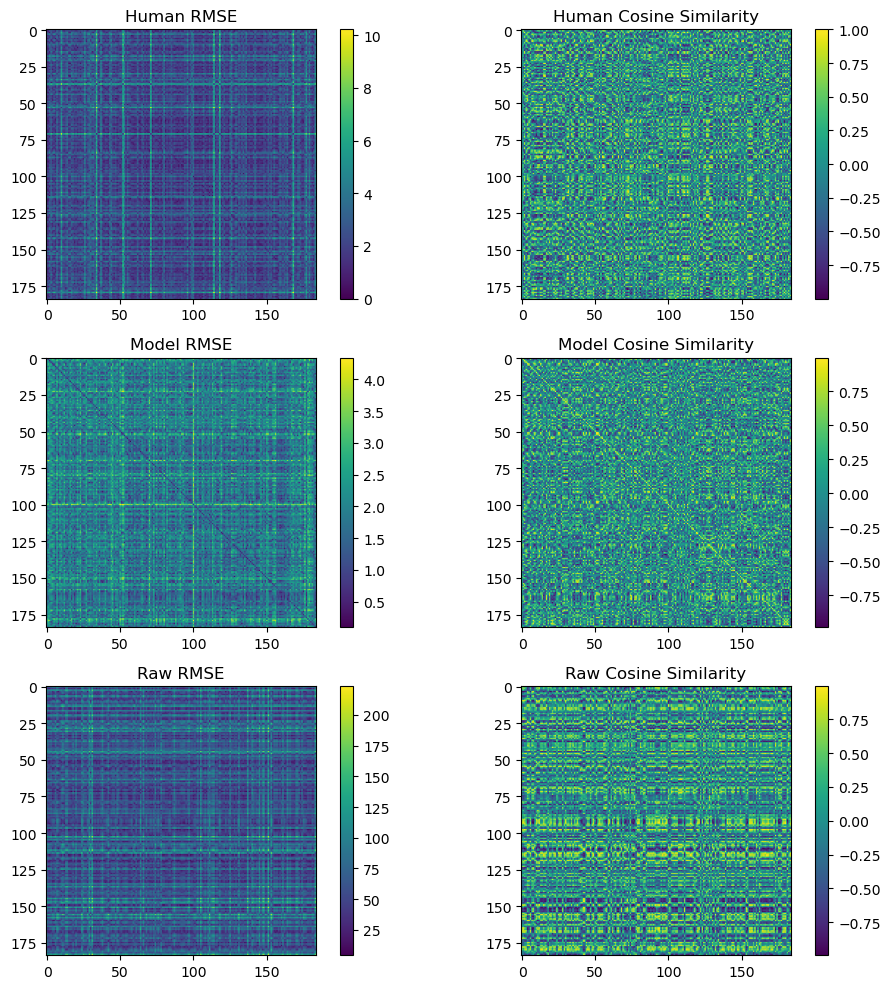

In [16]:
def pairwise_rmse(A, B):
    diff = A[:, np.newaxis, :] - B[np.newaxis, :, :]
    rmse_matrix = np.sqrt(np.mean(diff ** 2, axis=2))
    return rmse_matrix


# --- Compute matrices ---
raw_rmse_matrix = pairwise_rmse(raw_left_pca[:, :PC_i], raw_right_pca[:, :PC_i])
raw_cossim_matrix = cosine_similarity(raw_left_pca[:, :PC_i], raw_right_pca[:, :PC_i])

human_rmse_matrix = pairwise_rmse(human_left_pca[:, :PC_i], human_right_pca[:, :PC_i])
human_cossim_matrix = cosine_similarity(human_left_pca[:, :PC_i], human_right_pca[:, :PC_i])

model_rmse_matrix = pairwise_rmse(model_left_pca[:, :PC_i], model_right_pca[:, :PC_i])
model_cossim_matrix = cosine_similarity(model_left_pca[:, :PC_i], model_right_pca[:, :PC_i])

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

im1 = axs[0, 0].imshow(human_rmse_matrix, cmap='viridis')
axs[0, 0].set_title("Human RMSE")
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(human_cossim_matrix, cmap='viridis')
axs[0, 1].set_title("Human Cosine Similarity")
plt.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(model_rmse_matrix, cmap='viridis')
axs[1, 0].set_title("Model RMSE")
plt.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(model_cossim_matrix, cmap='viridis')
axs[1, 1].set_title("Model Cosine Similarity")
plt.colorbar(im4, ax=axs[1, 1])

im5 = axs[2, 0].imshow(raw_rmse_matrix, cmap='viridis')
axs[2, 0].set_title("Raw RMSE")
plt.colorbar(im5, ax=axs[2, 0])

im6 = axs[2, 1].imshow(raw_cossim_matrix, cmap='viridis')
axs[2, 1].set_title("Raw Cosine Similarity")
plt.colorbar(im6, ax=axs[2, 1])

plt.tight_layout()
plt.show()

## Retrieval curve

In [17]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances  # (import kept if used elsewhere)
from sklearn.metrics.pairwise import cosine_similarity  # (import kept if used elsewhere)


def style_ax(ax):
    """Unified styling: gray/black frame with optional alpha, dashed grid behind, semi-transparent grid, no tick spikes."""

    # Gray/black frame (spines) with alpha control
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

    # Scientific tick labels
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    # Grid under data layers
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Remove tick mark "spikes"
    ax.tick_params(axis='both', which='both', length=0)


def compute_retrieval_curve(sim_matrix):
    """Recall@K curve where the correct match for row i is column i.
    Returns an array of length N with recall at K=1..N.
    """
    n = sim_matrix.shape[0]
    match_ranks = []

    for i in range(n):
        sims = sim_matrix[i].copy()
        sorted_idx = np.argsort(sims)[::-1]  # descending order
        match_rank = np.where(sorted_idx == i)[0][0]
        match_ranks.append(match_rank)

    # recall@k: fraction of queries with rank < k
    recalls = np.zeros(n)
    for k in range(1, n + 1):
        recalls[k - 1] = np.mean([r < k for r in match_ranks])
    return recalls


def compute_precision_curve(sim_matrix):
    """Precision@K curve where only the exact self-match counts as correct.
    Returns an array of length N with precision at K=1..N.
    """
    n = sim_matrix.shape[0]
    precision_at_k = np.zeros(n)

    for i in range(n):
        sims = sim_matrix[i].copy()
        sorted_idx = np.argsort(sims)[::-1]
        for k in range(1, n + 1):
            top_k = sorted_idx[:k]
            num_correct = np.sum(top_k == i)
            precision_at_k[k - 1] += num_correct / k

    precision_at_k /= n
    return precision_at_k


# ---- Expect the following variables to exist in calling scope ----
# raw_cossim_matrix, human_cossim_matrix, model_cossim_matrix
# SIM_DIR, PC_i

# Compute retrieval curves (assuming each i is the ground-truth match for query i)
recalls_raw = compute_retrieval_curve(raw_cossim_matrix)
recalls_human = compute_retrieval_curve(human_cossim_matrix)
recalls_model = compute_retrieval_curve(model_cossim_matrix)

precisions_raw = compute_precision_curve(raw_cossim_matrix)
precisions_human = compute_precision_curve(human_cossim_matrix)
precisions_model = compute_precision_curve(model_cossim_matrix)

n_samples = len(recalls_human)
k_values = np.arange(1, n_samples + 1)
chance_recall = k_values / n_samples

# === Recall Curve ===
fig_recall, ax_recall = plt.subplots(figsize=(5, 4), constrained_layout=True)

# Ensure grid/line orders: grid (z=0) < lines (z=1/2) < markers if any
ax_recall.plot(k_values, recalls_human, label="Human", linestyle='-.', zorder=2)
ax_recall.plot(k_values, recalls_model, label="Model", linewidth=2, zorder=2)
ax_recall.plot(k_values, chance_recall, label="Random Chance", linestyle=':', color='grey', zorder=1)

ax_recall.set_xlabel("Top-K")
ax_recall.set_ylabel("Recall")

# Legend with subtle background for readability
leg = ax_recall.legend(frameon=True)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.8)
leg.get_frame().set_edgecolor('gray')

style_ax(ax_recall)
fig_recall.savefig(os.path.join(SIM_DIR, f"PC1-{PC_i}_recall.pdf"), dpi=300, transparent=True)
plt.close(fig_recall)

# === Precision Curve ===
fig_prec, ax_prec = plt.subplots(figsize=(5, 4), constrained_layout=True)

ax_prec.plot(k_values, precisions_human, label="Human", linestyle='-.', zorder=2)
ax_prec.plot(k_values, precisions_model, label="Model", linewidth=2, zorder=2)

ax_prec.set_xlabel("Top-K")
ax_prec.set_ylabel("Precision")

leg2 = ax_prec.legend(frameon=True)
leg2.get_frame().set_facecolor('white')
leg2.get_frame().set_alpha(0.5)
leg2.get_frame().set_edgecolor('gray')

style_ax(ax_prec)
fig_prec.savefig(os.path.join(SIM_DIR, f"PC1-{PC_i}_precision.pdf"), dpi=300, transparent=True)
plt.close(fig_prec)

# Compute AUCs using trapezoidal integration (normalize by N for 0..1 scale)
x_axis = np.arange(1, n_samples + 1)
auc_recall_raw = np.trapz(recalls_raw, x=x_axis) / n_samples
auc_recall_human = np.trapz(recalls_human, x=x_axis) / n_samples
auc_recall_model = np.trapz(recalls_model, x=x_axis) / n_samples

auc_prec_raw = np.trapz(precisions_raw, x=x_axis) / n_samples
auc_prec_human = np.trapz(precisions_human, x=x_axis) / n_samples
auc_prec_model = np.trapz(precisions_model, x=x_axis) / n_samples

print(f"AUC Recall - Human: {auc_recall_human:.4f}, Model: {auc_recall_model:.4f}")
print(f"AUC Precision - Human: {auc_prec_human:.4f}, Model: {auc_prec_model:.4f}")


AUC Recall - Human: 0.7457, Model: 0.9390
AUC Precision - Human: 0.0122, Model: 0.0208


In [18]:
def get_match_ranks(sim_matrix):
    ranks = []
    for i in range(sim_matrix.shape[0]):
        sims = sim_matrix[i].copy()
        sorted_idx = np.argsort(sims)[::-1]
        rank = np.where(sorted_idx == i)[0][0]
        ranks.append(rank)
    return np.array(ranks)


ranks_raw = get_match_ranks(raw_cossim_matrix)
ranks_human = get_match_ranks(human_cossim_matrix)
ranks_model = get_match_ranks(model_cossim_matrix)

# Combine into a DataFrame
import pandas as pd

rank_df = pd.DataFrame({
    "Raw": ranks_raw,
    "Human": ranks_human,
    "Model": ranks_model
})
# Total rank sum across the three methods
rank_df["Sum"] = rank_df.sum(axis=1)

# Mean pairwise rank difference
rank_df["AvgDiff"] = rank_df[["Raw", "Human", "Model"]].std(axis=1) * np.sqrt(3)

ranks_human = np.array(ranks_human)
ranks_model = np.array(ranks_model)

# Difference: positive → human better; negative → model better
diff = ranks_model - ranks_human

# Get indices of top differences
idx_human_better = np.argsort(diff)[-1]  # human ≫ model
idx_model_better = np.argsort(diff)[0]  # model ≫ human

# Identify examples
lowest_sum_idx = rank_df["Sum"].idxmin()
highest_sum_idx = rank_df["Sum"].idxmax()
highest_disagree_idx = rank_df["AvgDiff"].idxmax()

rank_df[["run_id", "scope_id"]] = segments[["run_id", "scope_id"]]
# Preview the rows
rank_df.loc[[lowest_sum_idx, highest_sum_idx, highest_disagree_idx, idx_human_better, idx_model_better]]

,Raw,Human,Model,Sum,AvgDiff,run_id,scope_id
10,1,1,0,2,1.000000,741,17
161,117,177,87,381,79.372539,594,24
100,182,0,0,182,182.000000,449,11
108,1,29,137,167,124.386494,495,32
9,65,178,2,245,154.457114,594,22


# Linear Regression and Extrapolation

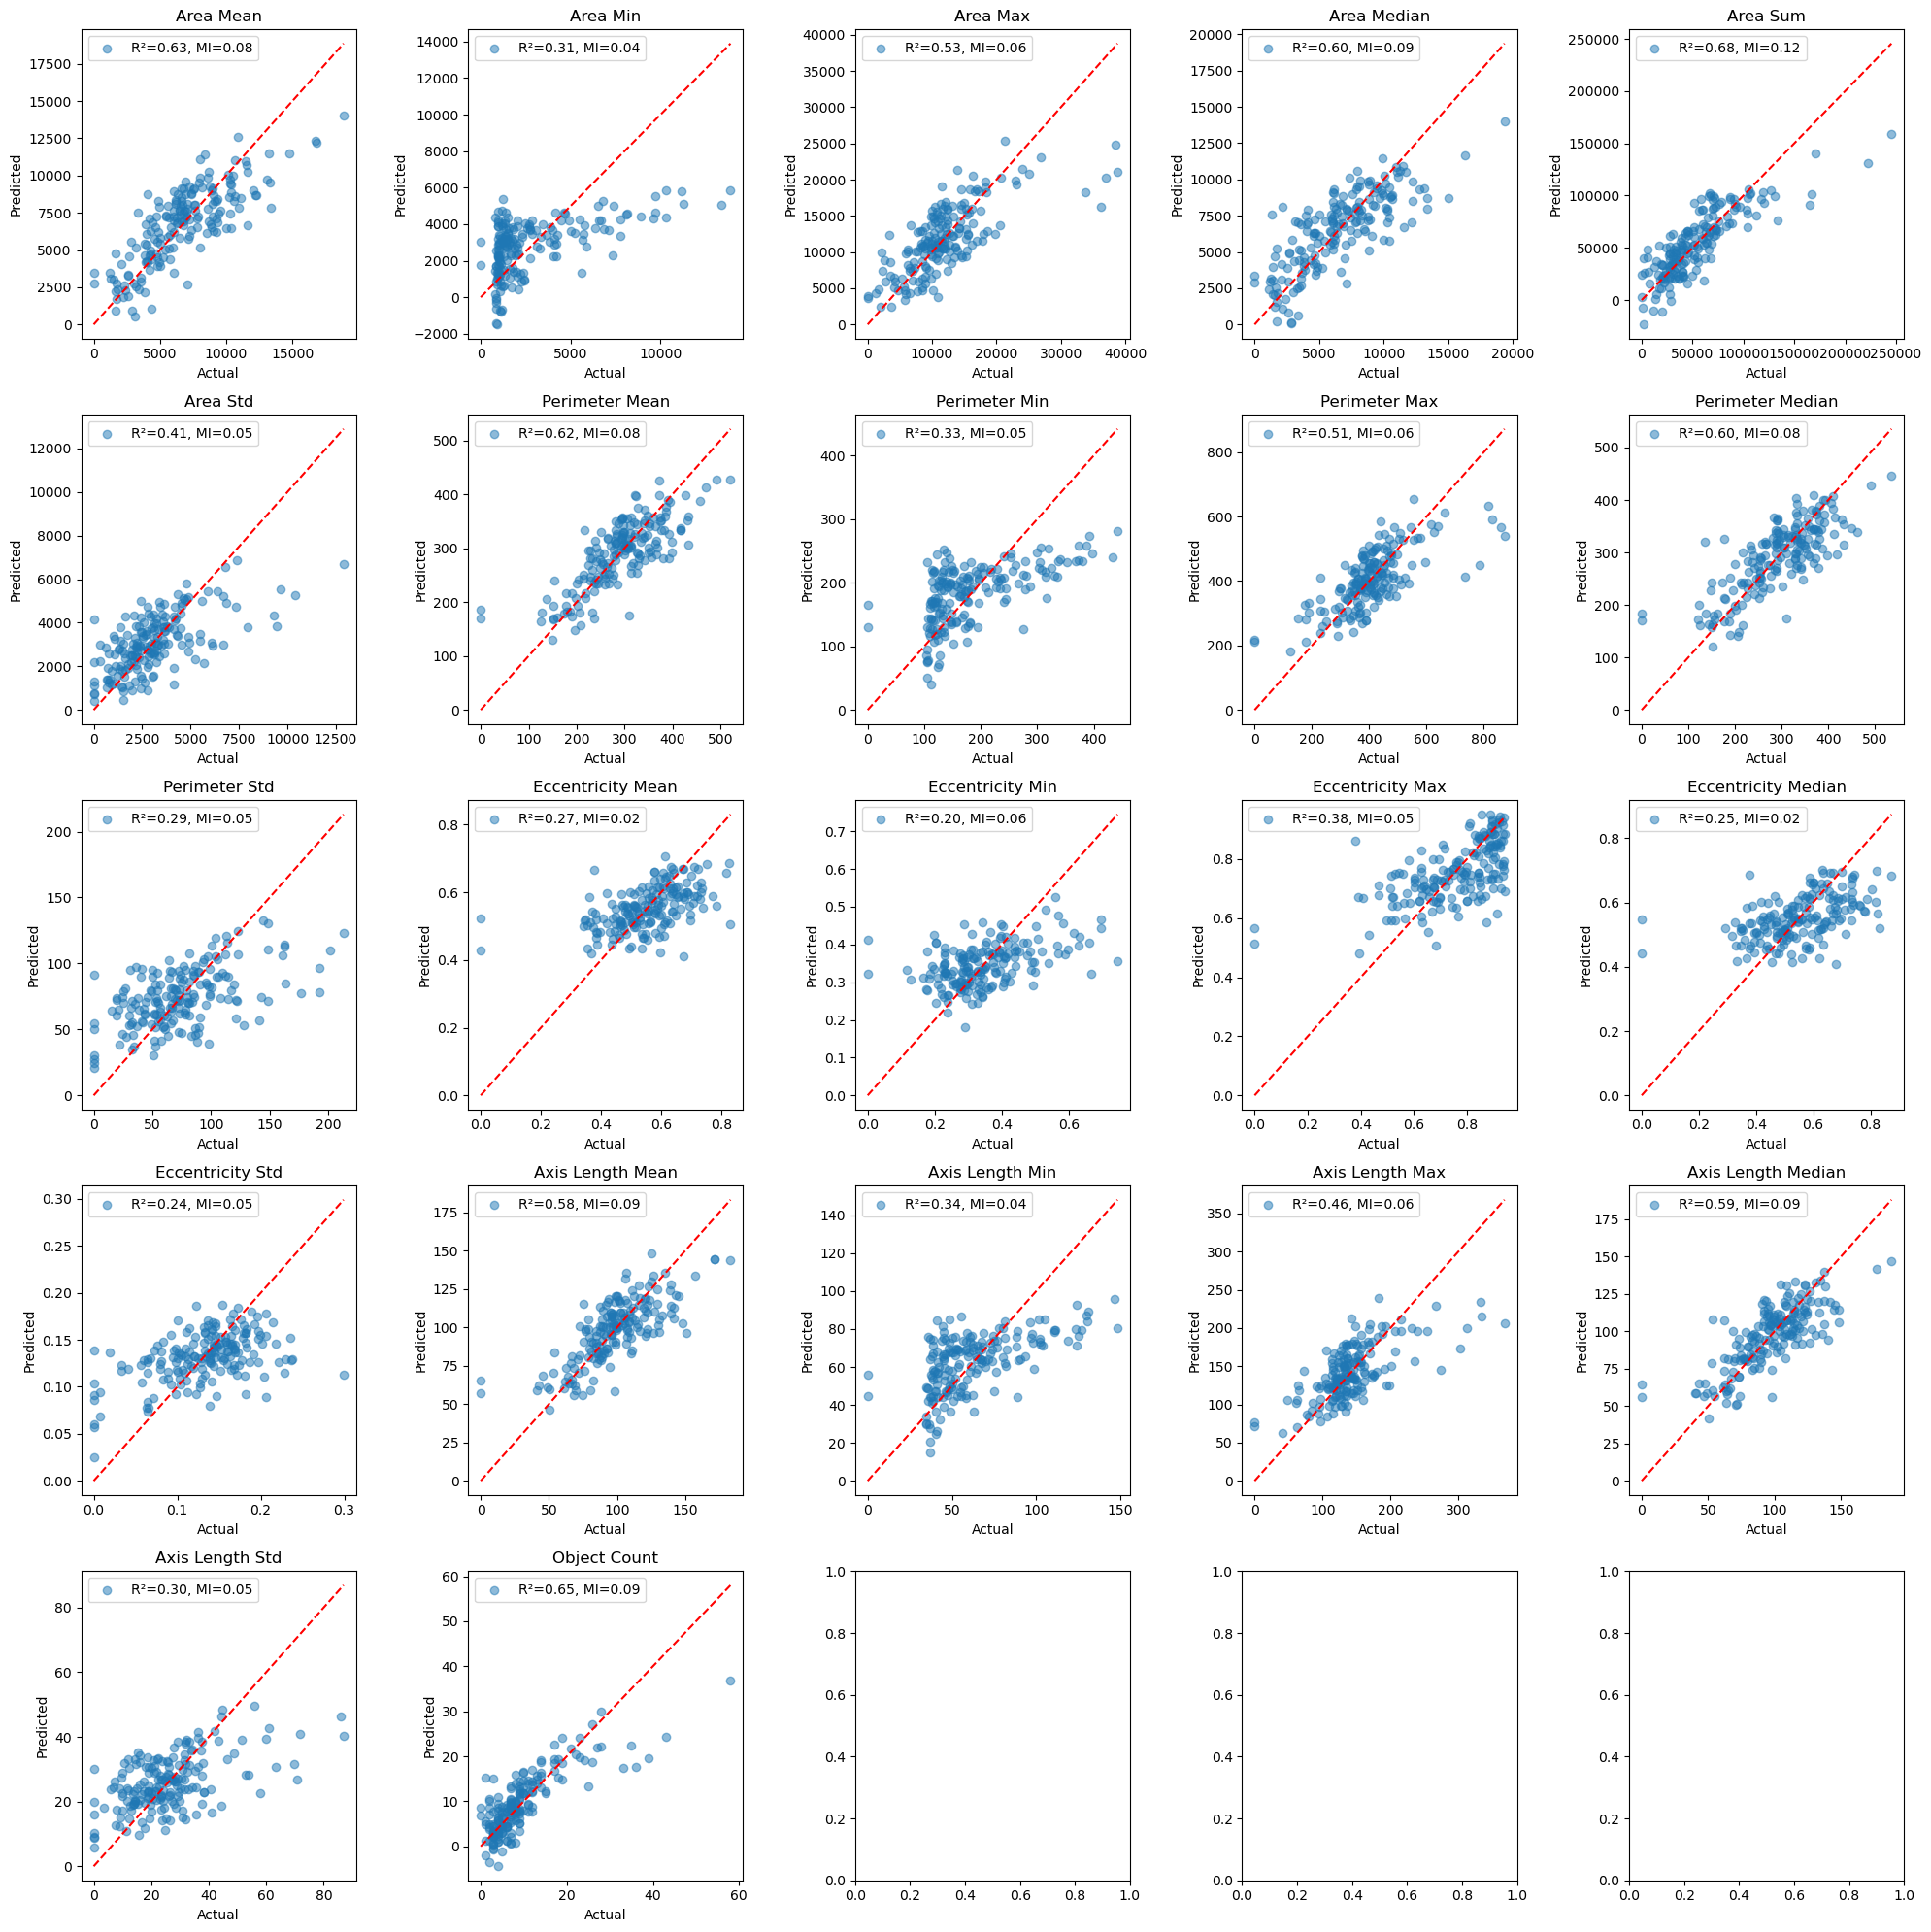

,Feature,Mutual Information
0,Area Mean,0.079982
1,Area Min,0.043566
2,Area Max,0.061564
3,Area Median,0.088663
4,Area Sum,0.120208
5,Area Std,0.053703
6,Perimeter Mean,0.077862
7,Perimeter Min,0.052535
8,Perimeter Max,0.059513
9,Perimeter Median,0.078894


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression

human_feature_names = [
    "Area Mean", "Area Min", "Area Max", "Area Median", "Area Sum", "Area Std",
    "Perimeter Mean", "Perimeter Min", "Perimeter Max", "Perimeter Median", "Perimeter Std",
    "Eccentricity Mean", "Eccentricity Min", "Eccentricity Max", "Eccentricity Median", "Eccentricity Std",
    "Axis Length Mean", "Axis Length Min", "Axis Length Max", "Axis Length Median", "Axis Length Std",
    "Object Count"
]
num_features = human_left.shape[1]
fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # Create a grid for 23 subplots
axes = axes.flatten()

mutual_info_scores = []

for i in range(num_features):
    human_feature = human_left[:, i]
    model_features = learned_left

    # Linear Regression
    reg = LinearRegression().fit(model_features, human_feature)
    predictions = reg.predict(model_features)
    r2 = r2_score(human_feature, predictions)

    # Mutual Information
    mi = mutual_info_regression(model_features, human_feature)
    mutual_info_scores.append(np.mean(mi))

    ax = axes[i]
    ax.scatter(human_feature, predictions, alpha=0.5, label=f"R²={r2:.2f}, MI={np.mean(mi):.2f}")
    ax.plot([min(human_feature), max(human_feature)], [min(human_feature), max(human_feature)], 'r--')
    ax.set_title(human_feature_names[i])
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.legend()

plt.tight_layout()
plt.show()

# Print mutual information scores
mutual_info_df = pd.DataFrame(
    {"Feature": human_feature_names, "Mutual Information": mutual_info_scores})
mutual_info_df


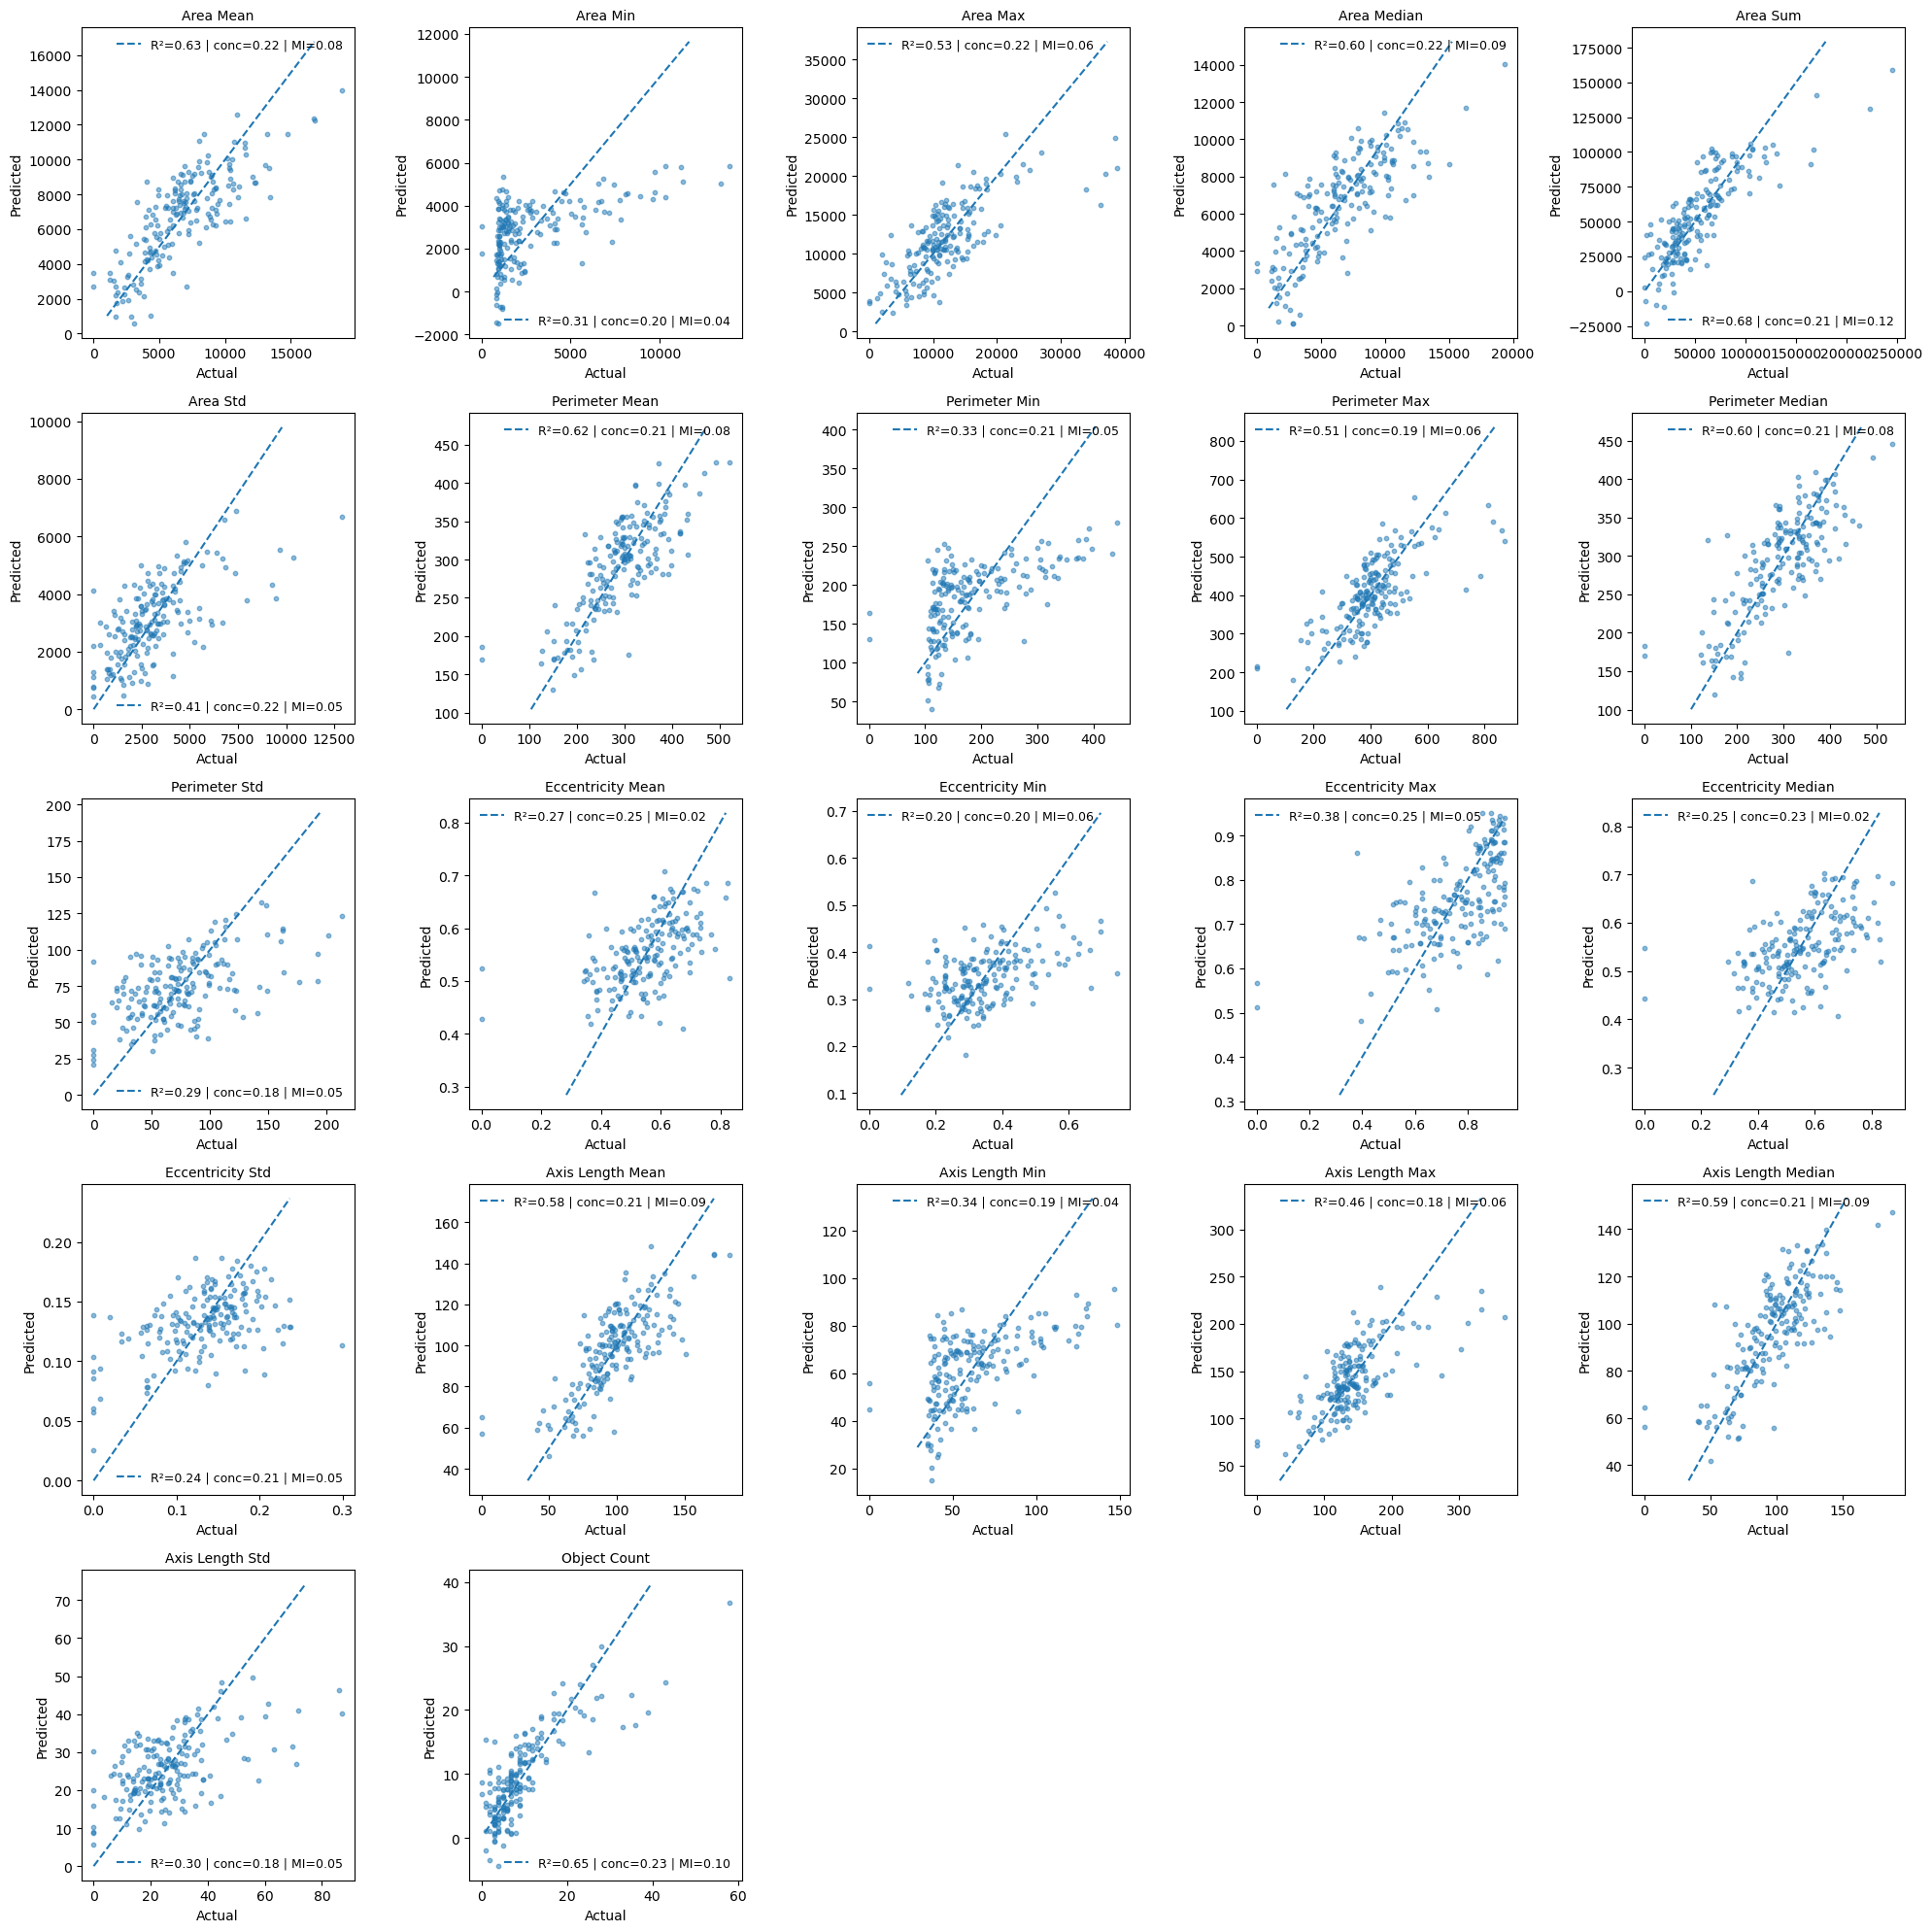

,Feature,N,R2,MI_mean,max_abs_beta,sum_abs_beta,concentration
4,Area Sum,184,0.676032,0.120199,23750.039062,111780.570312,0.212470
21,Object Count,184,0.650354,0.097412,4.828263,20.560820,0.234828
0,Area Mean,184,0.633066,0.079982,1655.961426,7477.689941,0.221454
6,Perimeter Mean,184,0.615361,0.077862,40.159695,191.912537,0.209260
9,Perimeter Median,184,0.604362,0.078718,41.332134,199.531128,0.207146
3,Area Median,184,0.600082,0.088673,1644.806030,7626.658203,0.215665
19,Axis Length Median,184,0.587449,0.088968,12.970045,61.865135,0.209650
16,Axis Length Mean,184,0.577284,0.085093,14.023677,65.461639,0.214227
2,Area Max,184,0.532755,0.061582,3311.002930,14923.251953,0.221869
8,Perimeter Max,184,0.513058,0.059423,61.681026,323.822296,0.190478


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression

# ---- Inputs ----
# human_left: (N, 22)
# learned_left_norm: (N, 13)   # recommended for coefficient interpretability
# If you only have learned_left (not normalized), you can swap it in, but concentration becomes less comparable.

X = model_left_norm  # (N, 13)
Y = human_left         # (N, 22)

human_feature_names = [
    "Area Mean", "Area Min", "Area Max", "Area Median", "Area Sum", "Area Std",
    "Perimeter Mean", "Perimeter Min", "Perimeter Max", "Perimeter Median", "Perimeter Std",
    "Eccentricity Mean", "Eccentricity Min", "Eccentricity Max", "Eccentricity Median", "Eccentricity Std",
    "Axis Length Mean", "Axis Length Min", "Axis Length Max", "Axis Length Median", "Axis Length Std",
    "Object Count"
]

assert Y.shape[1] == len(human_feature_names), "human_feature_names length mismatch."
num_features = Y.shape[1]

# ---- Plot layout (auto square-ish grid) ----
ncols = 5
nrows = ceil(num_features / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)  # flatten safely

rows = []

for i in range(num_features):
    y = Y[:, i].astype(float)

    # Remove NaNs (if any)
    mask = np.isfinite(y)
    X_i = X[mask]
    y_i = y[mask]

    # Skip if not enough data or constant target (R² undefined / meaningless)
    if len(y_i) < 5 or np.allclose(np.var(y_i), 0.0):
        ax = axes[i]
        ax.set_title(human_feature_names[i])
        ax.text(0.5, 0.5, "Insufficient / constant data", ha="center", va="center")
        ax.set_axis_off()

        rows.append({
            "Feature": human_feature_names[i],
            "N": len(y_i),
            "R2": np.nan,
            "MI_mean": np.nan,
            "max_abs_beta": np.nan,
            "sum_abs_beta": np.nan,
            "concentration": np.nan,
        })
        continue

    # ---- Linear regression ----
    reg = LinearRegression().fit(X_i, y_i)
    pred = reg.predict(X_i)

    r2 = r2_score(y_i, pred)

    beta = reg.coef_.ravel()
    abs_beta = np.abs(beta)

    max_abs_beta = float(abs_beta.max())
    sum_abs_beta = float(abs_beta.sum())
    concentration = float(max_abs_beta / sum_abs_beta) if sum_abs_beta > 0 else np.nan

    # ---- Mutual information (optional) ----
    # MI is nonnegative; we summarize by mean across 13 features.
    mi = mutual_info_regression(X_i, y_i, random_state=0)
    mi_mean = float(np.mean(mi))

    # ---- Plot ----
    ax = axes[i]
    ax.scatter(y_i, pred, alpha=0.5, s=10)

    # y=x reference line (use robust bounds)
    lo = np.nanpercentile(y_i, 1)
    hi = np.nanpercentile(y_i, 99)
    ax.plot([lo, hi], [lo, hi], linestyle="--")

    ax.set_title(human_feature_names[i], fontsize=10)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

    ax.legend(
        [f"R²={r2:.2f} | conc={concentration:.2f} | MI={mi_mean:.2f}"],
        loc="best",
        frameon=False,
        fontsize=9
    )

    rows.append({
        "Feature": human_feature_names[i],
        "N": int(len(y_i)),
        "R2": float(r2),
        "MI_mean": mi_mean,
        "max_abs_beta": max_abs_beta,
        "sum_abs_beta": sum_abs_beta,
        "concentration": concentration,
    })

# Turn off any unused axes
for j in range(num_features, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(rows)

# A reviewer-friendly view: sort by R2 (or by concentration)
summary_df_sorted = summary_df.sort_values(by="R2", ascending=False)

summary_df_sorted


In [21]:
summary_latex = (
    summary_df_sorted[["Feature", "R2", "concentration"]]
    .style.hide(axis="index")
    .format(escape="latex", precision=2)
    .to_latex(
        caption=(
            "Linear correspondence between learned features and human-defined metrics. "
            "Coefficients of determination (R$^2$) from linear regression models predicting each "
            "human-defined feature using the 13-dimensional learned feature representation. "
            "The concentration metric is defined as max($|\\beta|$)/$\\sum |\\beta|$, where "
            "$\\beta$ denotes regression coefficients computed from standardized latent features; "
            "lower values indicate distributed contributions from multiple latent dimensions."
        ),
        label="tab:latent_human_regression",
        position="ht",
        hrules=True,
    )
)

print(summary_latex)

\begin{table}[ht]
\caption{Linear correspondence between learned features and human-defined metrics. Coefficients of determination (R$^2$) from linear regression models predicting each human-defined feature using the 13-dimensional learned feature representation. The concentration metric is defined as max($|\beta|$)/$\sum |\beta|$, where $\beta$ denotes regression coefficients computed from standardized latent features; lower values indicate distributed contributions from multiple latent dimensions.}
\label{tab:latent_human_regression}
\begin{tabular}{lrr}
\toprule
Feature & R2 & concentration \\
\midrule
Area Sum & 0.68 & 0.21 \\
Object Count & 0.65 & 0.23 \\
Area Mean & 0.63 & 0.22 \\
Perimeter Mean & 0.62 & 0.21 \\
Perimeter Median & 0.60 & 0.21 \\
Area Median & 0.60 & 0.22 \\
Axis Length Median & 0.59 & 0.21 \\
Axis Length Mean & 0.58 & 0.21 \\
Area Max & 0.53 & 0.22 \\
Perimeter Max & 0.51 & 0.19 \\
Axis Length Max & 0.46 & 0.18 \\
Area Std & 0.41 & 0.22 \\
Eccentricity Max & 0.38

## Construct extrapolated images

In [22]:
from sklearn.linear_model import LinearRegression
from skimage import measure
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from training.networks_stylegan2 import SynthesisLayer, SynthesisBlock
import multiprocessing
from functools import partial
from concurrent.futures import ThreadPoolExecutor
import dnnlib
import legacy
import torch
import cv2

os.environ['CC'] = "/usr/bin/gcc-9"
os.environ['CXX'] = "/usr/bin/g++-9"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network_pkl = f"{WORKING_DIR}/models/network-snapshot-003024-patched.pkl"
# Feature names (22 total, one less than in your list for this placeholder)
human_feature_names = [
    "Area Mean", "Area Min", "Area Max", "Area Median", "Area Sum", "Area Std",
    "Perimeter Mean", "Perimeter Min", "Perimeter Max", "Perimeter Median", "Perimeter Std",
    "Eccentricity Mean", "Eccentricity Min", "Eccentricity Max", "Eccentricity Median", "Eccentricity Std",
    "Axis Length Mean", "Axis Length Min", "Axis Length Max", "Axis Length Median", "Axis Length Std",
    "Object Count"
]


def reset_noise_const(G, seed):
    torch.manual_seed(seed)

    for block in G.synthesis.children():
        for layer in block.children():
            if hasattr(layer, 'noise_const'):
                resolution = layer.resolution
                with torch.no_grad():
                    layer.noise_const.copy_(torch.randn([resolution, resolution]))


with dnnlib.util.open_url(network_pkl) as fp:
    models = legacy.load_network_pkl(fp)
    G = models['G_ema'].to(device)

G_seed = 4
reset_noise_const(G, G_seed)

# Run regression and store R² + MI
mutual_info_scores = []
r2_scores = []
selected_features = ["Axis Length Mean", "Object Count"]
feature_names = ["Mean Axis Length", "Object Count"]
selected_indices = [human_feature_names.index(f) for f in selected_features]

BATCH_SIZE = 16
predicts = {}
for feature_name, idx in zip(feature_names, selected_indices):
    MODIFY_DIR = f"{WORKING_DIR}/images/figure5/final_frames/modify_{human_feature_names[idx]}/seed_{G_seed}"
    os.makedirs(MODIFY_DIR, exist_ok=True)
    human_feature = human_left[:, idx]

    std = np.std(human_feature)
    # Linear Regression
    model_features = sm.add_constant(learned_left)  # shape: (N, d+1)
    reg = sm.OLS(human_feature, model_features).fit()
    bias = reg.params[0]
    weights = reg.params[1:]  # numpy array of shape (d,)
    predictions = reg.predict(model_features)
    r2 = r2_score(human_feature, predictions)

    # Mutual Information
    mi = mutual_info_regression(learned_left, human_feature)
    mutual_info_scores.append(np.mean(mi))
    r2_scores.append(r2)

    # Plot
    fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
    # fig.subplots_adjust(left=0.2)
    ax.scatter(human_feature, predictions, alpha=0.5, label=f"Prediction, $R^2$={r2:.4f}", zorder=3)
    ax.plot([min(human_feature), max(human_feature)], [min(human_feature), max(human_feature)], 'r--',
            label="Ideal fit (y=x)", zorder=2)
    ax.set_xlabel(f"Actual {feature_name}")
    ax.set_ylabel(f"Predicted {feature_name}")
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    # ax.text(0.05, 0.95, f"$R^2$ = {r2:.2f}", transform=ax.transAxes,
    #         ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    leg = ax.legend(frameon=True)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_alpha(0.8)
    style_ax(ax)
    fig.savefig(os.path.join(MODIFY_DIR, f"{human_feature_names[idx]}.pdf"), bbox_inches="tight")
    plt.close(fig)

    unit_vector = weights / np.sum(np.square(weights))
    multiple = std * unit_vector * 2
    print(f"feature {human_feature_names[idx]}, std={std}, min={min(human_feature)}, max={max(human_feature)}")
    final_images_stack = []

    predicts[human_feature_names[idx]] = pd.DataFrame()
    predicts[human_feature_names[idx]]['human_original'] = human_feature
    for shift in [-2, -1, 0, 1, 2]:
        new_zs = (learned_left + shift * multiple)
        pred = reg.predict(sm.add_constant(new_zs))
        predicts[human_feature_names[idx]][f"pred_{shift}"] = pred
        # print(pred)
        new_zs = torch.Tensor(new_zs).to(device)
        final_images = []

        with torch.no_grad():  # Disable gradients for efficiency
            for i in range(0, len(new_zs), BATCH_SIZE):
                batch_zs = new_zs[i:(i + BATCH_SIZE), :]
                synth_images = G(batch_zs, None, noise_mode="const")
                synth_images = (synth_images + 1) * 127.5
                synth_images = synth_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
                final_images.append(synth_images)

        final_images = np.concatenate(final_images, axis=0)
        final_images_stack.append(final_images)

    final_images_stack = np.concatenate(final_images_stack, axis=2)

    predicts[human_feature_names[idx]][["run_id", "scope_id"]] = segments[["run_id", "scope_id"]]
    for i, ((_, segment), img) in enumerate(zip(segments.iterrows(), final_images_stack)):
        # filename = f"{segment['run_id']}_{segment['scope_id']}.png"
        # cv2.imwrite(os.path.join(MODIFY_DIR, filename), img)
        folder_name = os.path.join(MODIFY_DIR, f"Run{segment['run_id']}_Scope{segment['scope_id']}")
        os.makedirs(folder_name, exist_ok=True)
        im_width = 512
        for j in range(5):
            cv2.imwrite(os.path.join(folder_name, f"{j - 2}.tif"), img[:, im_width * j:im_width * (j + 1)])
    predicts[human_feature_names[idx]].to_csv(os.path.join(MODIFY_DIR, f"{human_feature_names[idx]}.csv"))
# Return scores
pd.DataFrame({
    "Feature": selected_features,
    "R²": r2_scores,
    "Mutual Information": mutual_info_scores
})


feature Axis Length Mean, std=26.563924031559722, min=0.0, max=183.0809872427963
feature Object Count, std=8.323814467378197, min=0.0, max=58.0


,Feature,R²,Mutual Information
0,Axis Length Mean,0.577284,0.085093
1,Object Count,0.650354,0.100435


In [23]:
segments

,fname,run_id,scope_id,left,right,left_features,right_features,raw_left_flat,raw_right_flat,raw_rmse_pair_PC1-1,...,raw_rmse_random_PC1-13,raw_cossim_random_PC1-13,human_rmse_pair_PC1-13,human_cossim_pair_PC1-13,human_rmse_random_PC1-13,human_cossim_random_PC1-13,model_rmse_pair_PC1-13,model_cossim_pair_PC1-13,model_rmse_random_PC1-13,model_cossim_random_PC1-13
0,Run0492_scope24-00_1441.tif,492,24,"{'area': (8793.708300000002, 6377.292000000001...","{'area': (8038.974600000001, 1015.642800000000...","[0.7083466, 1.1856904, -0.13861401, 2.112981, ...","[1.591602, 1.4961723, -0.047045007, 2.071851, ...","[1.4483172, 1.4076538, 1.3263272, 1.3263272, 1...","[-0.34282383, 0.02872385, -0.11060653, -0.0177...",217.229492,...,79.038109,-0.146241,1.219320,-0.093542,1.768997,-0.682603,0.348624,0.820937,1.322121,-0.373466
1,Run0700_scope41-00_1441.tif,700,41,"{'area': (6282.097854545455, 4217.410800000001...","{'area': (6252.633000000001, 3952.346400000001...","[0.7504266, -2.714271, 2.3328302, 1.5180347, 0...","[0.95118374, -3.6490953, 2.244628, 1.3387246, ...","[-3.2623637, -2.589554, -1.0604413, 0.49925384...","[-0.27471197, -0.27471197, -0.27471197, -0.274...",25.166893,...,68.790565,-0.096108,0.498494,0.676583,1.489454,-0.200954,0.372299,0.954070,1.760809,-0.071430
2,Run0706_scope27-00_1441.tif,706,27,"{'area': (2601.1692000000003, 858.178800000000...","{'area': (2398.4630181818184, 845.056800000000...","[-0.16330916, -1.7863975, 2.0388603, -3.484819...","[0.13299607, -1.0008057, 1.592911, -3.6066594,...","[-0.14744166, -0.056103818, -0.08654976, -0.17...","[0.67232776, 0.76761705, 0.98995876, 1.085248,...",27.258043,...,54.056870,-0.277631,0.350787,0.963993,2.279446,0.030210,0.254764,0.983464,2.244945,-0.077140
3,Run0621_scope84-00_1441.tif,621,84,"{'area': (10289.263015384617, 1272.83400000000...","{'area': (10248.774075000001, 1892.19240000000...","[-1.3012351, -2.3219447, 1.4528881, 2.3084006,...","[-1.7416288, -2.8767443, 2.050012, 3.1466055, ...","[-0.93394643, -0.93394643, -0.8960118, -0.8960...","[0.41337055, 0.31067964, 0.10529779, -0.202774...",209.984070,...,62.980755,0.566945,1.468578,0.808263,4.107829,-0.650578,0.595753,0.918259,1.999634,-0.175845
4,Run0569_scope15-00_1441.tif,569,15,"{'area': (6159.466800000001, 2711.005200000000...","{'area': (4511.343600000001, 1152.111600000000...","[0.4913165, 0.4364758, -1.5716842, 0.114236325...","[-0.09809436, 0.54470605, -1.7328148, 0.044240...","[0.87291414, 0.64565754, 0.68353367, 0.7592858...","[0.9450394, 0.22558512, -0.767947, -0.87072617...",46.978329,...,37.450657,-0.418489,1.000397,0.443908,0.879469,0.545248,0.501444,0.878047,0.733381,0.693438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Run0725_scope2-00_1441.tif,725,2,"{'area': (16833.276514285717, 1154.736, 38539....","{'area': (13676.076450000002, 934.286400000000...","[-0.6462484, -1.1099418, -2.5890605, 1.7708976...","[-0.7133879, -0.4270717, -1.1077064, 2.4874187...","[-1.1752379, -0.9457665, -0.55238694, -0.42126...","[1.1912704, 1.0368149, 0.9209733, 0.72790396, ...",76.064964,...,44.206356,0.567753,1.478173,0.914724,2.835032,0.473052,0.827243,0.849694,1.694747,0.157668
180,Run0233_scope53-00_1441.tif,233,53,"{'area': (4696.738714285715, 1049.760000000000...","{'area': (4227.064842857143, 818.8128000000002...","[-1.3291476, -1.1445009, 1.6200897, -1.4361082...","[-0.7710766, -1.7114176, 1.9932611, -1.9981687...","[-2.3878489, -2.2636685, -2.2388325, -2.338176...","[0.4571076, 0.23494533, 0.19051288, 0.23494533...",121.261703,...,43.111813,0.668657,0.882259,0.714147,0.401490,0.949117,0.433642,0.950223,1.320048,0.464986
181,Run0746_scope39-00_1441.tif,746,39,"{'area': (8183.170800000002, 2561.414400000000...","{'area': (8580.374861538463, 2170.378800000000...","[0.22984502, 0.7414129, -0.75125855, 2.1487021...","[0.1797563, 0.6041641, -0.6649329, 2.9801767, ...","[0.74522084, 0.915368, 0.915368, 0.70268404, 0...","[-1.7408627, -0.92145616, -0.72635937, -0.2191...",84

# Get binary images in matlab then process

# Get segmented image feature

In [24]:
import numpy as np
from functools import partial
import os
import cv2
from skimage import measure
import pandas as pd

human_feature_names = [
    "Area Mean", "Area Min", "Area Max", "Area Median", "Area Sum", "Area Std",
    "Perimeter Mean", "Perimeter Min", "Perimeter Max", "Perimeter Median", "Perimeter Std",
    "Eccentricity Mean", "Eccentricity Min", "Eccentricity Max", "Eccentricity Median", "Eccentricity Std",
    "Axis Length Mean", "Axis Length Min", "Axis Length Max", "Axis Length Median", "Axis Length Std",
    "Object Count"
]
MATLAB_SEGMENT_DICT = {
    "Axis Length Mean": f"{WORKING_DIR}/images/figure5/final_frames/modify_Axis Length Mean/seed_4_segmented",
    "Object Count": f"{WORKING_DIR}/images/figure5/final_frames/modify_Object Count/orig_segmented"
}
run_id = 292
scope_id = 31


def compute_stats(region_props):
    """Compute aggregate statistics (mean, min, max, median, sum, std, count)."""
    if not region_props:
        return {
            "area": (0, 0, 0, 0, 0, 0),
            "perimeter": (0, 0, 0, 0, 0),
            "eccentricity": (0, 0, 0, 0, 0),
            "axis_length": (0, 0, 0, 0, 0),
            "count": 0
        }

    areas = [p.area for p in region_props]
    perimeters = [p.perimeter for p in region_props]
    eccentricities = [p.eccentricity for p in region_props]
    axis_lengths = [p.major_axis_length for p in region_props]

    return {
        "area": (np.mean(areas), np.min(areas), np.max(areas), np.median(areas), np.sum(areas), np.std(areas)),
        "perimeter": (
            np.mean(perimeters), np.min(perimeters), np.max(perimeters), np.median(perimeters), np.std(perimeters)),
        "eccentricity": (
            np.mean(eccentricities), np.min(eccentricities), np.max(eccentricities), np.median(eccentricities),
            np.std(eccentricities)),
        "axis_length": (np.mean(axis_lengths), np.min(axis_lengths), np.max(axis_lengths), np.median(axis_lengths),
                        np.std(axis_lengths)),
        "count": len(region_props)
    }


# Convert human-defined features into arrays
def extract_human_features(human_dict):
    """Flatten dictionary values into a numeric array."""
    return np.hstack([
        human_dict['area'],  # (mean, min, max, median, sum)
        human_dict['perimeter'],
        human_dict['eccentricity'],
        human_dict['axis_length'],
        [human_dict['count']]  # Single value
    ])


def calculate_single_image_features(image, feature_idx):
    """Helper function to calculate features for a single image, suitable for parallel execution."""
    synth_labeled = measure.label(image)
    synth_props = measure.regionprops(synth_labeled)
    synth_stats = compute_stats(synth_props)
    synth_features = extract_human_features(synth_stats)
    return synth_features[feature_idx]


# Collect results here: {feature_name: {image_name: value}}
matrix = {fn: {} for fn in MATLAB_SEGMENT_DICT.keys()}


def list_images(folder):
    exts = ('.tif', '.tiff', '.png', '.jpg', '.jpeg', '.bmp')
    return sorted([f for f in os.listdir(folder) if f.lower().endswith(exts)])


for feature_name, matlab_segment_dir in MATLAB_SEGMENT_DICT.items():
    image_dir = os.path.join(matlab_segment_dir, f"Run{run_id}_Scope{scope_id}")
    if not os.path.isdir(image_dir):
        print(f"[WARN] Missing directory: {image_dir}")
        continue

    images = list_images(image_dir)
    if not images:
        print(f"[WARN] No images found in: {image_dir}")
        continue

    feat_idx = human_feature_names.index(feature_name)

    for img_name in images:
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"[WARN] Failed to read: {img_path}")
            continue

        # If the image is multi-channel, collapse to a single channel
        if img.ndim == 3:
            # Use luminance-ish conversion; region labeling just needs nonzero mask
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        try:
            value = calculate_single_image_features(img, feat_idx)
        except Exception as e:
            print(f"[ERROR] {img_name} ({feature_name}): {e}")
            continue

        matrix[feature_name][img_name] = value

# Build a DataFrame: rows = feature_name, cols = image names (sorted union)
import re


def numeric_key(name):
    """Extract numeric part from filenames like '-2.tif' or '10.tif'."""
    stem = os.path.splitext(name)[0]
    try:
        return int(stem)
    except ValueError:
        # fallback if no integer found
        nums = re.findall(r"-?\d+", stem)
        return int(nums[0]) if nums else stem


# Replace this line:
# all_image_names = sorted({name for d in matrix.values() for name in d.keys()})
all_image_names = sorted({name for d in matrix.values() for name in d.keys()},
                         key=numeric_key)
df = pd.DataFrame(index=list(MATLAB_SEGMENT_DICT.keys()), columns=all_image_names, dtype=float)

for feature_name, per_image in matrix.items():
    for img_name, val in per_image.items():
        df.at[feature_name, img_name] = val

df.loc["Axis Length Mean", :] *= 512 / 600 * 2
df

[WARN] Missing directory: /home/xavier/Documents/DAE_project/images/figure5/final_frames/modify_Axis Length Mean/seed_4_segmented/Run292_Scope31
[WARN] Missing directory: /home/xavier/Documents/DAE_project/images/figure5/final_frames/modify_Object Count/orig_segmented/Run292_Scope31


""
Axis Length Mean
Object Count


## Check corresponding original features

In [25]:
import numpy as np
import pandas as pd


# Your function (kept here for completeness)
def extract_human_features(human_dict):
    """Flatten dictionary values into a numeric array."""
    return np.hstack([
        human_dict['area'],  # (mean, min, max, median, sum) -> 5
        human_dict['perimeter'],  # 5
        human_dict['eccentricity'],  # 5
        human_dict['axis_length'],  # 5
        [human_dict['count']]  # 1  (total = 21)
    ])


# 1) Map each dict -> 1D feature array (handle missing/None safely)
def _safe_extract(d):
    if isinstance(d, dict):
        try:
            return extract_human_features(d)
        except KeyError:
            # Missing key(s): return NaNs of correct length
            return np.full(len(human_feature_names), np.nan, dtype=float)
    # Not a dict / None / NaN
    return np.full(len(human_feature_names), np.nan, dtype=float)


features_list = segments["left"].map(_safe_extract)

# 2) Stack to 2D matrix (n_rows, n_features)
features_matrix = np.vstack(features_list.to_numpy())

# 3) Build a DF with the correct column names, aligned to original index
features_df = pd.DataFrame(features_matrix,
                           columns=human_feature_names,
                           index=segments.index)

# 4) Concatenate IDs + features
human_features = pd.concat([segments[["run_id", "scope_id"]], features_df], axis=1)
feature_cols = list(MATLAB_SEGMENT_DICT.keys())

# Select the row(s)
row = human_features.loc[
    (human_features["run_id"] == run_id) & (human_features["scope_id"] == scope_id),
    ["run_id", "scope_id"] + feature_cols
]

print(row)

    run_id  scope_id  Axis Length Mean  Object Count
12     292        31         96.131112          14.0


# Case study

In [26]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. Configuration ---
# Define project directories and file paths
# Please adjust these paths to match your system's layout
OUT_DIR = f"{WORKING_DIR}/images/figure5/final_frames"

# Path to your pre-saved pickle file.
SEGMENTS_PKL_PATH = os.path.join(OUT_DIR, "segments.pkl")


# --- Helper Function ---


def flatten_stats(stats_dict):
    """Flatten nested human-defined stats into a single vector for analysis."""
    flat_list = []
    # Sort keys to ensure consistent feature order
    for key in sorted(stats_dict.keys()):
        if key != 'count':
            # This handles nested tuples/lists of numbers
            if isinstance(stats_dict[key], (list, tuple)):
                flat_list.extend(stats_dict[key])
            else:
                flat_list.append(stats_dict[key])
        else:
            flat_list.append(stats_dict[key])
    return np.array(flat_list)


# --- 2. Data Loading from Pickle ---
print(f"Loading pre-calculated data from {SEGMENTS_PKL_PATH}...")
if not os.path.exists(SEGMENTS_PKL_PATH):
    raise FileNotFoundError(f"The specified pickle file was not found: {SEGMENTS_PKL_PATH}")

# Load the data from the pickle file
with open(SEGMENTS_PKL_PATH, 'rb') as fp:
    segments = pkl.load(fp)

# The pickle file should have the correct index, but we can double-check
# CORRECTED: Check for inequality instead of using the 'in' operator, as index.name can be None.
if segments.index.name != 'fname':
    if 'fname' in segments.columns:
        segments.set_index('fname', inplace=True)
    elif 'Unnamed: 0' in segments.columns:
        segments.rename(columns={'Unnamed: 0': 'fname'}, inplace=True)
        segments.set_index('fname', inplace=True)

# No need to convert columns with ast.literal_eval, as pickle preserves object types.
print("Data loaded successfully. Pickle format preserves object types.")

# --- 3. Cosine Similarity Analysis ---
print("\nCalculating cosine similarities...")
all_similarities = []

# Process Model Features
# Use the actual column names from the DataFrame
left_model_feats = np.stack(segments['left_features'].values)
right_model_feats = np.stack(segments['right_features'].values)
scaler_model = StandardScaler()
pca_model = PCA(n_components=5)
left_pcs_model = pca_model.fit_transform(scaler_model.fit_transform(left_model_feats))
right_pcs_model = pca_model.transform(scaler_model.transform(right_model_feats))

# Process Human Features
# Use the actual column names from the DataFrame
left_human_feats = np.stack(segments['left'].apply(flatten_stats).values)
right_human_feats = np.stack(segments['right'].apply(flatten_stats).values)
scaler_human = StandardScaler()
pca_human = PCA(n_components=5)
left_pcs_human = pca_human.fit_transform(scaler_human.fit_transform(left_human_feats))
right_pcs_human = pca_human.transform(scaler_human.transform(right_human_feats))

for i, fname in enumerate(segments.index):
    # Model similarity
    v1_m, v2_m = left_pcs_model[i], right_pcs_model[i]
    model_sim = np.dot(v1_m, v2_m) / (np.linalg.norm(v1_m) * np.linalg.norm(v2_m))

    # Human similarity
    v1_h, v2_h = left_pcs_human[i], right_pcs_human[i]
    human_sim = np.dot(v1_h, v2_h) / (np.linalg.norm(v1_h) * np.linalg.norm(v2_h))

    all_similarities.append({'fname': fname, 'model': model_sim, 'human': human_sim})

df_pivot = pd.DataFrame(all_similarities).set_index('fname')

# --- 4. Find and Display Case Studies ---
print("\n--- Case Study Analysis ---")

# Case Study 1: Human features fail, Model succeeds
human_fail_model_success = df_pivot[(df_pivot['human'] < 0.1) & (df_pivot['model'] > 0.8)]
print("\n✅ Case 1: Top 6 Examples of Human Features Failing while Model Succeeds")
# Sort by the human score to show the most dramatic failures first, and show only the top 6
print(human_fail_model_success.sort_values(by='human').head(3))

# Case Study 2: Human features succeed, Model fails
human_success_model_fail = df_pivot[(df_pivot['human'] > 0.9) & (df_pivot['model'] < 0.2)]
print("\n❌ Case 2: Human Features Succeed, Model Fails")
if human_success_model_fail.empty:
    print("No instances found where human features succeeded and model features failed.")
else:
    print(human_success_model_fail)

# NEW: Case Study 3: Both methods succeed (Positive Control)
both_succeed = df_pivot[(df_pivot['human'] > 0.9) & (df_pivot['model'] > 0.9)]
print("\n👍 Case 3: Top 6 Examples Where Both Methods Succeed")
# Sort by the model score to show the best agreements
print(both_succeed.sort_values(by='model', ascending=False).head(3))


Loading pre-calculated data from /home/xavier/Documents/DAE_project/images/figure5/final_frames/segments.pkl...
Data loaded successfully. Pickle format preserves object types.

Calculating cosine similarities...

--- Case Study Analysis ---

✅ Case 1: Top 6 Examples of Human Features Failing while Model Succeeds
                                model     human
fname                                          
Run0594_scope22-00_1441.tif  0.877695 -0.752510
Run0658_scope16-00_1441.tif  0.852031 -0.684117
Run0767_scope24-00_1441.tif  0.838756 -0.511041

❌ Case 2: Human Features Succeed, Model Fails
No instances found where human features succeeded and model features failed.

👍 Case 3: Top 6 Examples Where Both Methods Succeed
                                model     human
fname                                          
Run0706_scope27-00_1441.tif  0.991165  0.973611
Run0449_scope10-00_1441.tif  0.986919  0.974787
Run0449_scope11-00_1441.tif  0.981556  0.980056


# Extra

In [27]:
import pandas as pd
from scipy.stats import pearsonr

# Compute correlation for each dimension
correlation_results = {}

for i, feature_name in enumerate(human_feature_names):
    corr, p_value = pearsonr(human_left[:, i], human_right[:, i])
    correlation_results[feature_name] = {"Pearson Correlation": corr, "P-value": p_value}

# Convert to DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient="index")
correlation_df

,Pearson Correlation,P-value
Area Mean,0.593360,6.957075e-19
Area Min,0.256947,4.300044e-04
Area Max,0.512308,1.056563e-13
Area Median,0.547179,9.232794e-16
Area Sum,0.818073,1.356847e-45
Area Std,0.351420,1.001577e-06
Perimeter Mean,0.519732,4.028777e-14
Perimeter Min,0.273756,1.697859e-04
Perimeter Max,0.501292,4.234162e-13
Perimeter Median,0.512743,9.991821e-14


In [28]:
correlation_results = {}
for i in range(learned_left.shape[1]):
    corr, p_value = pearsonr(learned_left[:, i], learned_right[:, i])
    correlation_results[f"feature_{i}"] = {"Pearson Correlation": corr, "P-value": p_value}

# Convert to DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient="index")
correlation_df

,Pearson Correlation,P-value
feature_0,0.788042,3.376813e-40
feature_1,0.878501,2.753628e-60
feature_2,0.863363,5.864463e-56
feature_3,0.825894,3.643638e-47
feature_4,0.715281,3.899033e-30
feature_5,0.855171,7.927885e-54
feature_6,0.850667,1.036713e-52
feature_7,0.824557,6.849929e-47
feature_8,0.689238,2.891503e-27
feature_9,0.678498,3.618893e-26


In [29]:
import numpy as np


def compute_column_space(matrix, tol=1e-10):
    """Compute the column space of a matrix using SVD."""
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    rank = np.sum(S > tol)  # Number of significant singular values
    return U[:, :rank]  # The first 'rank' columns of U span the column space


# Compute column space bases
human_left_col_space = compute_column_space(human_left)
human_right_col_space = compute_column_space(human_right)
learned_left_col_space = compute_column_space(learned_left)
learned_right_col_space = compute_column_space(learned_right)
from scipy.linalg import subspace_angles

# Compute principal angles between column spaces
human_space_similarity = subspace_angles(human_left_col_space, human_right_col_space)
learned_space_similarity = subspace_angles(learned_left_col_space, learned_right_col_space)

# Print the largest principal angle (closer to 0 means more similar)
print(f"Max Principal Angle - Human: {np.max(human_space_similarity):.4f}")
print(f"Max Principal Angle - Model: {np.max(learned_space_similarity):.4f}")


Max Principal Angle - Human: 1.5609
Max Principal Angle - Model: 1.2812


In [30]:
def projection_distance(A, B):
    """Compute the chordal distance between two subspaces."""
    P_A = A @ A.T  # Projection matrix of A
    P_B = B @ B.T  # Projection matrix of B
    return np.linalg.norm(P_A - P_B, 'fro')  # Frobenius norm


# Compute projection distances
human_proj_dist = projection_distance(human_left_col_space, human_right_col_space)
learned_proj_dist = projection_distance(learned_left_col_space, learned_right_col_space)

print(f"Projection Distance - Human: {human_proj_dist:.4f}")
print(f"Projection Distance - Model: {learned_proj_dist:.4f}")


Projection Distance - Human: 5.7487
Projection Distance - Model: 3.3401


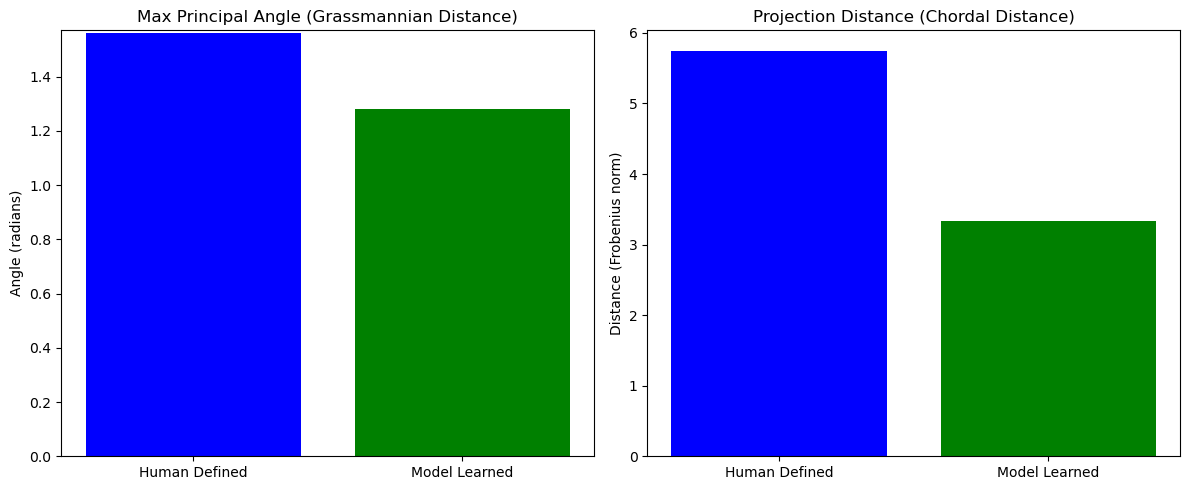

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for visualization
methods = ["Human Defined", "Model Learned"]

# Principal Angles Visualization (Max Principal Angle)
principal_angles = [np.max(human_space_similarity), np.max(learned_space_similarity)]

# Projection Distances Visualization (Chordal Distance)
projection_distances = [human_proj_dist, learned_proj_dist]

# Create bar plots for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Principal Angles Plot
ax[0].bar(methods, principal_angles, color=['blue', 'green'])
ax[0].set_title("Max Principal Angle (Grassmannian Distance)")
ax[0].set_ylabel("Angle (radians)")
ax[0].set_ylim(0, np.pi / 2)  # Max principal angle is within [0, π/2]

# Projection Distance Plot
ax[1].bar(methods, projection_distances, color=['blue', 'green'])
ax[1].set_title("Projection Distance (Chordal Distance)")
ax[1].set_ylabel("Distance (Frobenius norm)")

# Show plots
plt.tight_layout()
plt.show()


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()

# Normalize left and right features before PCA
human_left_norm = scaler.fit_transform(human_left)
human_right_norm = scaler.transform(human_right)

learned_left_norm = scaler.fit_transform(learned_left)
learned_right_norm = scaler.transform(learned_right)

# Apply PCA after normalization
human_pca = PCA(n_components=13)
human_left_pca = human_pca.fit_transform(human_left_norm)
human_right_pca = human_pca.transform(human_right_norm)

learned_pca = PCA(n_components=13)
model_left_pca = learned_pca.fit_transform(learned_left_norm)
model_right_pca = learned_pca.transform(learned_right_norm)


In [33]:
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression


def compute_consistency_score(left_pca, right_pca):
    """Compute a single consistency score by averaging Pearson correlations."""
    correlations = [pearsonr(left_pca[:, i], right_pca[:, i])[0] for i in range(left_pca.shape[1])]
    return correlations


# Compute consistency scores
human_consistency = compute_consistency_score(human_left_pca, human_right_pca)
model_consistency = compute_consistency_score(model_left_pca, model_right_pca)


def mutual_info_consistency(left_pca, right_pca):
    """Compute average mutual information between left and right features."""
    mi_scores = [mutual_info_regression(left_pca[:, i].reshape(-1, 1), right_pca[:, i])[0] for i in
                 range(left_pca.shape[1])]
    return mi_scores


# Compute Mutual Information Scores
human_mi = mutual_info_consistency(human_left_pca, human_right_pca)
model_mi = mutual_info_consistency(model_left_pca, model_right_pca)

In [34]:
human_data = {"Method": "Human defined"}
model_data = {"Method": "Model defined"}
for i in range(len(human_consistency)):
    human_data[f"Correlation PC{i + 1}"] = human_consistency[i]
    model_data[f"Correlation PC{i + 1}"] = model_consistency[i]
for i in range(len(human_mi)):
    human_data[f"MI PC{i + 1}"] = human_mi[i]
    model_data[f"MI PC{i + 1}"] = model_mi[i]

table_df = pd.DataFrame([human_data, model_data])
table_df

,Method,Correlation PC1,Correlation PC2,Correlation PC3,Correlation PC4,Correlation PC5,Correlation PC6,Correlation PC7,Correlation PC8,Correlation PC9,...,MI PC4,MI PC5,MI PC6,MI PC7,MI PC8,MI PC9,MI PC10,MI PC11,MI PC12,MI PC13
0,Human defined,0.521411,0.473949,0.185297,0.458049,0.279737,0.120475,0.344209,0.313713,0.191116,...,0.161821,0.026174,0.000000,0.122329,0.099768,0.000000,0.000000,0.000000,0.00000,0.000000
1,Model defined,0.840759,0.877669,0.839168,0.799176,0.833350,0.753214,0.763253,0.655866,0.706455,...,0.547847,0.576885,0.512112,0.381256,0.293959,0.294225,0.077389,0.204005,0.14837,0.062005


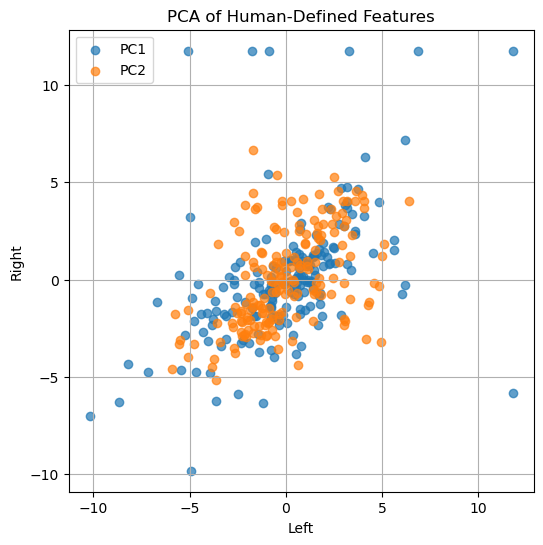

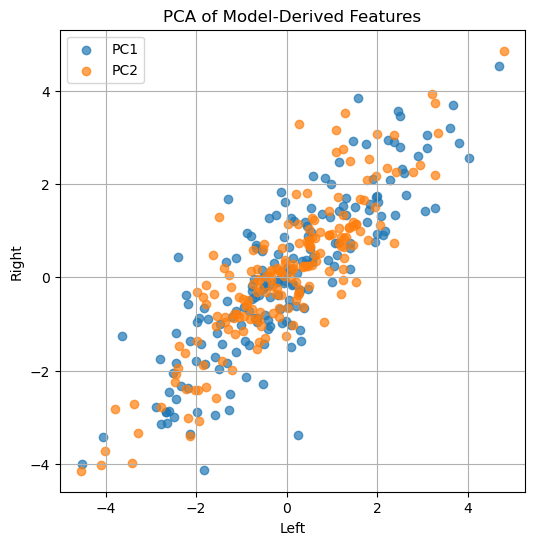

In [35]:
# Assuming human_left, human_right, learned_left, learned_right are your datasets
scaler = StandardScaler()
human_left_std = scaler.fit_transform(human_left)
human_right_std = scaler.transform(human_right)
learned_left_std = scaler.fit_transform(learned_left)
learned_right_std = scaler.transform(learned_right)

# Human-defined features
pca_human = PCA(n_components=2)
human_combined = np.vstack([human_left_std, human_right_std])
human_pca = pca_human.fit_transform(human_combined)
human_left_pca = human_pca[:len(human_left_std)]
human_right_pca = human_pca[len(human_left_std):]

# Model-derived features
pca_model = PCA(n_components=2)
model_combined = np.vstack([learned_left_std, learned_right_std])
model_pca = pca_model.fit_transform(model_combined)
model_left_pca = model_pca[:len(learned_left_std)]
model_right_pca = model_pca[len(learned_left_std):]


def plot_pca_scatter(left_pca, right_pca, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(left_pca[:, 0], right_pca[:, 0], alpha=0.7, label='PC1')
    plt.scatter(left_pca[:, 1], right_pca[:, 1], alpha=0.7, label='PC2')
    plt.title(title)
    plt.xlabel('Left')
    plt.ylabel('Right')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot for human-defined features
plot_pca_scatter(human_left_pca, human_right_pca, 'PCA of Human-Defined Features')

# Plot for model-derived features
plot_pca_scatter(model_left_pca, model_right_pca, 'PCA of Model-Derived Features')


In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()

# Normalize left and right features before PCA
human_left_norm = scaler.fit_transform(human_left)
human_right_norm = scaler.transform(human_right)

learned_left_norm = scaler.fit_transform(learned_left)
learned_right_norm = scaler.transform(learned_right)

# Apply PCA after normalization
human_pca = PCA(n_components=13)
human_left_pca = human_pca.fit_transform(human_left_norm)
human_right_pca = human_pca.transform(human_right_norm)

learned_pca = PCA(n_components=13)
model_left_pca = learned_pca.fit_transform(learned_left_norm)
model_right_pca = learned_pca.transform(learned_right_norm)


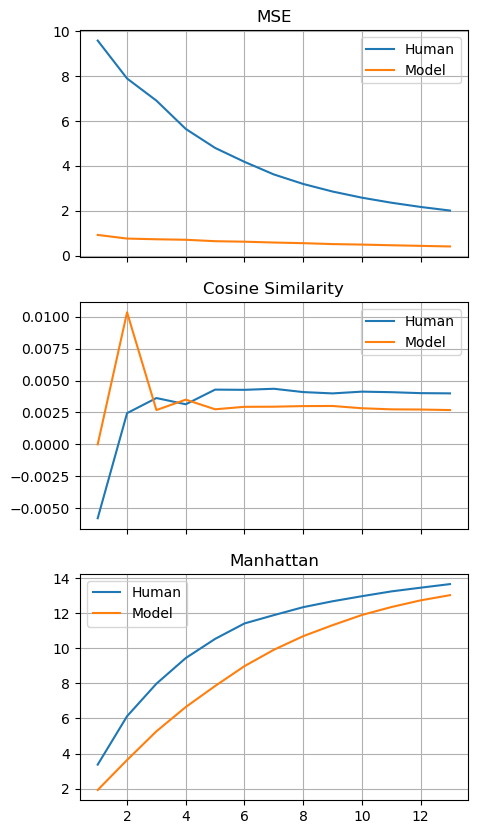

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances

n_dims = 13
mse = []
cossim = []
man = []
for n_dim in range(1, n_dims + 1):
    # Apply PCA to reduce feature dimensions (e.g., keep 5 principal components)
    human_pca = PCA(n_components=n_dim)

    # Reduce dimensionality separately for left and right
    human_left_pca = human_pca.fit_transform(human_left_norm)
    human_right_pca = human_pca.transform(human_right_norm)
    if n_dim > 13:
        ldim = 13
    else:
        ldim = n_dim
    learned_pca = PCA(n_components=ldim)
    model_left_pca = learned_pca.fit_transform(learned_left_norm)
    model_right_pca = learned_pca.transform(learned_right_norm)

    # Compute MSE
    mse_human = mean_squared_error(human_left_pca, human_right_pca)
    mse_model = mean_squared_error(model_left_pca, model_right_pca)
    mse.append((n_dim, mse_human, mse_model))
    tmp = cosine_similarity(human_left_pca, human_right_pca)
    cossim.append(
        (n_dim, np.mean(cosine_similarity(human_left_pca, human_right_pca)),
         np.mean(cosine_similarity(model_left_pca, model_right_pca))))
    man.append((n_dim, np.mean(manhattan_distances(human_left_pca, human_right_pca)),
                np.mean(manhattan_distances(model_left_pca, model_right_pca))))
mse = np.array(mse)
cossim = np.array(cossim)
man = np.array(man)
fig, axis = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
axis[0].plot(mse[:, 0], mse[:, 1], label='Human')
axis[0].plot(mse[:, 0], mse[:, 2], label='Model')
axis[0].set_title("MSE")
axis[0].grid(True)
axis[0].legend()
axis[1].plot(cossim[:, 0], cossim[:, 1], label='Human')
axis[1].plot(cossim[:, 0], cossim[:, 2], label='Model')
axis[1].set_title("Cosine Similarity")
axis[1].grid(True)
axis[1].legend()
axis[2].plot(man[:, 0], man[:, 1], label='Human')
axis[2].plot(man[:, 0], man[:, 2], label='Model')
axis[2].set_title("Manhattan")
axis[2].grid(True)
axis[2].legend()
plt.show()